# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
from datetime import datetime
from IPython.display import display, HTML
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
pd.set_option('display.max_columns', 400)
pd.set_option('display.max_rows', 400)

In [3]:
from sklearn import metrics
from sklearn.decomposition import LatentDirichletAllocation

In [30]:
values2017_dict = dict()
values2017_dict['PRAEGENDE_JUGENDJAHRE'] = {-1: 'unknown', 0:'unknown',
1: '40ies - war years (Mainstream, O+W)',
2:'40ies - reconstruction years (Avantgarde, O+W)',
3:'50ies - economic miracle (Mainstream, O+W)',
4:'50ies - milk bar / Individualisation (Avantgarde, O+W)',
5:'60ies - economic miracle (Mainstream, O+W)',
6:'60ies - generation 68 / student protestors (Avantgarde, W)',
7:'60ies - opponents to the building of the Wall (Avantgarde, O)',
8:'70ies - family orientation (Mainstream, O+W)',
9:'70ies - peace movement (Avantgarde, O+W)',
10:'80ies - Generation Golf (Mainstream, W)',
11:'80ies - ecological awareness (Avantgarde, W)',
12:'80ies - FDJ / communist party youth organisation (Mainstream, O)',
13:'80ies - Swords into ploughshares (Avantgarde, O)',
14:'90ies - digital media kids (Mainstream, O+W)',
15:'90ies - ecological awareness (Avantgarde, O+W)'
}
values2017_dict['D19_KONSUMTYP'] = {
-1: 'unknown',
1: 'Universal',
2: 'Versatile',
3: 'Gourmet',
4: 'Family',
5: 'Informed',
6: 'Modern',
9: 'Inactive'
}

# Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

## Read Data and drop useless features

In [4]:
# load in the data
azdias = pd.read_csv('./arvato_data/Udacity_AZDIAS_052018.csv', sep=';', 
                     low_memory=False, index_col='LNR')
customers = pd.read_csv('./arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';', 
                        low_memory=False, index_col='LNR')

KeyboardInterrupt: 

In [ ]:
customers['EINGEFUEGT_AM'].head()
# LNR
# 9626      1992-02-12 00:00:00
# 9628                      NaN
# 143872    1992-02-10 00:00:00
# 143873    1992-02-10 00:00:00
# 143874    1992-02-12 00:00:00

The column 'EINGEFUEGT_AM' represents a date. Translated from german, it means 'INSEARTED_AT' It's meaning is unclear and not described in the acompanying Excle files. I drop it from all dataset

In [ ]:
azdias.drop(['EINGEFUEGT_AM'], axis=1, inplace=True)
customers.drop(['EINGEFUEGT_AM'], axis=1, inplace=True)

In [ ]:
print(azdias.shape)
azdias.head()

In [ ]:
print(customers.shape)
customers.head()

In [ ]:
mailout = pd.read_csv('./arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', 
                      sep=';', index_col='LNR')
test = pd.read_csv('./arvato_data/Udacity_MAILOUT_052018_TEST.csv', 
                      sep=';', index_col='LNR')

In [ ]:
mailout.drop(['EINGEFUEGT_AM'], axis=1, inplace=True)
test.drop(['EINGEFUEGT_AM'], axis=1, inplace=True)

In [ ]:
print(mailout.shape)
mailout.head()

In [ ]:
mailout['RESPONSE'].value_counts()

In [ ]:
#532/42430  # 0.012538

In [ ]:
print(test.shape)
test.head()

In [ ]:
# Be sure to add in a lot more cells (both markdown and code) to document your
# approach and findings!

## Exploratory analysis

### Dealing with unknown values

Columns with the broad information about the customers have no missing values.

In [ ]:
customers[['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP']].isnull().sum()

Other columns are common for the 4 datasets: azdias, customers, mailout_train and testm data. Here is the percentage of missing values in each column

In [ ]:
# ----- check missing values
azdias_nulls = azdias.isnull().sum()
customers_nulls = customers.drop(['CUSTOMER_GROUP', 'ONLINE_PURCHASE',
                                  'PRODUCT_GROUP'], axis=1).isnull().sum()
mailout_nulls = mailout.drop("RESPONSE", axis=1).isnull().sum()
test_nulls = test.isnull().sum()
#
acmt_nulls = pd.concat([azdias_nulls/len(azdias), customers_nulls/len(customers),
                        mailout_nulls/len(mailout), test_nulls/len(test)], axis=1)
acmt_nulls.columns = ['azdias', 'customers', 'mailout', 'test']
#
display(HTML('<H3> Prozent of missing values in each dataset </H3> '))
acmt_nulls

In [ ]:
print('Frequncy of percentage of missing values')
acmt_nulls.hist(bins=50, layout=(1,4), figsize=(15,2), log=True, sharey=True);
#ax[0].set_ylabel('frequency')

The table above shows that nearly each column has explicitely unknown values (empty strings in CSV file).
Around 100 columns in each dataset have few missing value () and over 200 columns have around 20-25% missing values.

At the same time, from data documentation we know, that 

    -1 always encodes unknown values
    0 sometime encodes unknown values and sometimes is meaningful
    9 sometime encodes unknown values and sometimes is meaningful
    
Therefore I replace missing values with -1.

In [ ]:
azdias = azdias.fillna(-1)
display(azdias.head())
azdias.to_pickle('arvato_data/azdias_cleaned.pkl')

In [ ]:
customers = customers.fillna(-1)
display(customers.head())
customers.to_pickle('arvato_data/customers_cleaned.pkl')

In [ ]:
mailout = mailout.fillna(-1)
display(mailout.head())
mailout.to_pickle('arvato_data/mailout_cleaned.pkl')

In [ ]:
test = test.fillna(-1)
display(test.head())
test.to_pickle('arvato_data/test_cleaned.pkl')

### Feature Selection before Customer Segmentation

In Part 1 - Customer Segmentation Report - the unsupervised algorithms should be built on a small number of relevant features. In the absence of domain-specific knowledge, I rely on Machine Learning algorithms to perform feature selection. 

Strictly speaking, before applying any ML algorithm, one should think about 

* a way of dealing with categorical features
* feature normalization

With all 364 features being categorical or ordinal this is a problem on itself.

##### Preparing data for supervised learning

Manual exploratory analysis for 347 columns is infeasible for the time of the capstone project. So use ML methods to determine which columns are most relevant for distinguishing customers from general population. 

I combine the azdias and customers datasets and define the binary variable 'is_customer'. Then I consider predicting 'is_customer' as binary classification (supervised learning). Many classification algorithms also return the feature importance. 

In [ ]:
if 'azdias' not in dir():
    azdias = pd.read_pickle('arvato_data/azdias_cleaned.pkl')
print('adzias', azdias.shape)

In [ ]:
if 'customers' not in dir():
    customers = pd.read_pickle('arvato_data/customers_cleaned.pkl')
print('customers',customers.shape)

##### Reformulate problem as binary classification customer/not.  

Concatenate  customer and azdias dataset (= data) and set a response variable (is_customer)

In [ ]:
is_customer = pd.concat([pd.Series(1, index=customers.index),
                         pd.Series(0, index=azdias.index)], axis=0, verify_integrity=True, copy=True)
data = pd.concat([customers.drop(['CUSTOMER_GROUP', 'ONLINE_PURCHASE',
                                  'PRODUCT_GROUP'], axis=1),
                  azdias], axis=0, verify_integrity=True, copy=True)


In [ ]:
data.head()

Shuffle data before classification

In [ ]:
# shuffle data
is_customer = is_customer.sample(frac=1.0)
data = data.loc[is_customer.index]

##### Important features from Random forest

As I already mentioned, before applying any ML algorithm, one should think about a way of dealing with categorical features and feature normalization.

Fortunately tree-based models like RandomForest or GradientBoosting Regressor are insensitive to feature scaling and can work with the data as they are.  The python implementations (here, scikit-learn) also provides automatical calculation of feature importance.  I keep the categorical features in numerical form as they are. This is not ideal, but enough to estimate importance of each feature. Those are the features that distinguish customers from general population.

I encode bbject (string) columns in numeric form.

In [ ]:
object_columns = data.select_dtypes(include='object').columns.tolist()
object_columns

In [ ]:
data[object_columns].head()

In [ ]:
from sklearn.preprocessing import LabelEncoder
les = dict()
for colu in object_columns:
    tmp = pd.concat([data[colu].astype(str), 
                     mailout[colu].astype(str), 
                     test[colu].astype(str)], axis=1)
    les[colu] = LabelEncoder().fit(tmp)
    data[colu] = les[colu].transform(data[colu].astype(str))

In [ ]:
data = data.astype(int)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=1200, min_samples_leaf=64)

In [ ]:
%%time
rf.fit(data, is_customer)

##### Important features

In [ ]:
feature_importances = pd.Series(rf.feature_importances_, index=data.columns).sort_values(ascending=False)
feature_importances.head(25)

In [ ]:
feature_importances.head(25)[::-1].plot.barh(figsize=(7,7));

##### Useless features

In [ ]:
feature_importances.tail(25)

# Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

##### Read cleaned data

In [ ]:
if 'adzias' not in dir():
    azdias = pd.read_pickle('arvato_data/azdias_cleaned.pkl')
print('adzias', azdias.shape)

In [ ]:
if 'customers' not in dir():
    customers = pd.read_pickle('arvato_data/customers_cleaned.pkl')
print('customers',customers.shape)

## Compare distributions for the top-10 features

In [ ]:
#data.groupby(is_customer)[colu].value_counts().reset_index(level=0).rename(columns={'level_0':'is_customer'})

In [ ]:
# tmp = data.groupby(is_customer)[colu].value_counts().reset_index(level=0).rename(columns={'level_0':'is_customer',
#                                                                                  colu: 'n_people'}).reset_index()
# for i in [0,1]:
#     tmp.loc[tmp.is_customer==i, 'percent_people'] = \
#               tmp.loc[tmp.is_customer==i, 'n_people']/tmp.loc[tmp.is_customer==i, 'n_people'].sum(axis=0)
# display(tmp)

In [ ]:
is_customer = pd.concat([pd.Series(1, index=customers.index),
                         pd.Series(0, index=azdias.index)], axis=0, verify_integrity=True, copy=True)
data = pd.concat([customers.drop(['CUSTOMER_GROUP', 'ONLINE_PURCHASE',
                                  'PRODUCT_GROUP'], axis=1),
                  azdias], axis=0, verify_integrity=True, copy=True)

In [ ]:
top10_columns = ['D19_SOZIALES', 'D19_KONSUMTYP_MAX', 'ALTERSKATEGORIE_GROB', 'D19_KONSUMTYP',
                 'VK_ZG11', 'VK_DISTANZ', 'CJT_TYP_6', 'CJT_TYP_5',  'CJT_TYP_3', 'PRAEGENDE_JUGENDJAHRE']
# 'EXTSEL992'  need further clarification

In [ ]:
import seaborn as sns

In [ ]:
# ----- empty plots from seavborn
# fig, ax = plt.subplots(5,2, figsize=(15,20))
# for i, colu in enumerate(top10_columns):
#     n = azdias[colu].nunique()
#     # ----- tmp DataFrame:
#     # ----- percentage of people for each category, calculated separately for customers and not-customers
#     #tmp = gr[colu].value_counts().reset_index(level=0).rename(columns={'level_0':'is_customer'})
#     tmp = data.groupby(is_customer)[colu].value_counts().reset_index(level=0).rename(
#                         columns={'level_0':'is_customer', colu: 'n_people'}).reset_index()
    
#     for c in [0,1]:
#         tmp.loc[tmp.is_customer==c, 'percent_people'] = \
#                   tmp.loc[tmp.is_customer==c, 'n_people']/tmp.loc[tmp.is_customer==c, 'n_people'].sum(axis=0)
    
#     #display(tmp)
#     # ----- visualize
#     if n<20:
#         #tmp.plot.barh(ax=ax[i//2, i%2], title=colu, c='is_customer')
#         _ = sns.catplot(ax=ax[i//2, i%2], kind='bar', 
#                             x=colu, y='percent_people', hue='is_customer', data=tmp)
#     else:
#         #tmp.plot.hist(ax=ax[i//2, i%2], title=colu, c='is_customer', bins=100, log=True)
#         _ = sns.lineplot(ax=ax[i//2, i%2], lw=3, 
#                                x=colu, y='percent_people', hue='is_customer', data=tmp)
# display(fig)
# plt.close(fig)

In [ ]:
for i, colu in enumerate(top10_columns):
    n = azdias[colu].nunique()
    # ----- tmp DataFrame:
    # ----- percentage of people for each category, calculated separately for customers and not-customers
    #tmp = gr[colu].value_counts().reset_index(level=0).rename(columns={'level_0':'is_customer'})
    tmp = data.groupby(is_customer)[colu].value_counts().reset_index(level=0).rename(
                        columns={'level_0':'is_customer', colu: 'n_people'}).reset_index()
    
    for c in [0,1]:
        tmp.loc[tmp.is_customer==c, 'percent_people'] = \
                  tmp.loc[tmp.is_customer==c, 'n_people']/tmp.loc[tmp.is_customer==c, 'n_people'].sum(axis=0)
    
    #display(tmp)
    # ----- visualize
    ax = sns.catplot(kind='bar', x=colu, y='percent_people', hue='is_customer', data=tmp, 
                     height=3, aspect=4);
#display(fig)
#plt.close(fig)

We clearly see that 

1) customers significantly overrepresented in the group '1' and underrepresented in group '0' of 'D19_SOZIALES'. Unfortunately, 'D19_SOZIALES' is not documented in Excel files.

2) customers significantly overrepresented in the group '2' and underrepresented in group '8' of 'D19_KONSUMTYP_MAX'. Unfortunately, 'D19_KONSUMTYP_MAX' is not documented in Excel files.

3) customers overrepresented in the group '4'='>60 year' and underrepresented in groups '2'='30-45 years' and '3'=46-60 years' of 'ALTERKATETGORIE_GROB'.

4) customers overrepresented in the groups '3'='Gourmet' and '2'='Versatile' and significantly underrepresented in groups '9'='Inactive' and '4'=Family' of 'D19_Konsumtyp'='consumption type'.

5) customers significantly overrepresented in the groups with low values and underrepresented in groups with high values of 'VK_ZG11'. Unfortunately, 'VK_ZG11' is not documented in Excel files.

6) customers significantly overrepresented in the group '5' and underrepresented in groups '1', '2' and '3' of 'CJT_TYP_6'. Unfortunately, 'CJT_TYP_6' is not documented in Excel files.

7) customers significantly overrepresented in the group '5' and underrepresented in groups '1', '2' and '3' of 'CJT_TYP_5'. Unfortunately, 'CJT_TYP_5' is not documented in Excel files.

8) customers significantly overrepresented in the group '5' and underrepresented in groups '1', '2' and '3' of 'CJT_TYP_3'. Unfortunately, 'CJT_TYP_3' is not documented in Excel files.

9) customers are overrepresented in the following groups of 'PRAEGENDE_JUGENDJAHRE' = dominating movement in the person's youth (avantgarde or mainstream). This agrees with the previous finding abour the age of the customer.

    '0'='unknown', 
    '2'='40ies-reconstruction years (Avantgarde, O+W)', 
    '4'='50ies - milk bar / Individualisation (Avantgarde, O+W)', 
    '6'='60ies - generation 68 / student protestors (Avantgarde, W)' 

10) customers are underrepresented in the following groups of 'PRAEGENDE_JUGENDJAHRE' = dominating movement in the person's youth (avantgarde or mainstream). This agrees with the previous finding abour the age of the customer.

    '10'='80ies - Generation Golf (Mainstream, W)' 
    '12'='80ies - FDJ / communist party youth organisation (Mainstream, O)'
    '14'='90ies - digital media kids (Mainstream, O+W)'
    '15'='90ies - ecological awareness (Avantgarde, O+W)'



In [ ]:
#import itertools
#for cc in itertools.combinations(top10_columns, 2):
#    c1, c2 = cc
#    ctable = pd.crosstab(index=azdias[c1], columns=azdias[c2], normalize='all', margins=True)
#    display(ctable)

## Dimensionality Reduction

The most methods of dimensionality reduction (Principal Component Analysis, Factor Analysis) are meaningful for classical numerical features. For categorical features I propose to OHE-encode those and then use the Latent Dirichlet Allocation (LDA). 

Origonally developed to discover topics in text documents, LDA is intrinsically suited to work with high-dimensional sparse data. This exactly corresponds to our data after OHE. 

Simultaneously, the result of LDA can be interpreted as clustering. Each found 'topic' will correspond to cluster.

### OHE  top-N categorical  columns

All clustering algorithms are based on the concept of distance between points. For categorical data this concept is meaningful after applying One-Hot Encoding (OHE) to all categorical columns

In [ ]:
top10_columns = ['D19_SOZIALES', 'D19_KONSUMTYP_MAX', 'ALTERSKATEGORIE_GROB', 'D19_KONSUMTYP',
                 'VK_ZG11', 'VK_DISTANZ', 'CJT_TYP_6', 'CJT_TYP_5',  'CJT_TYP_3', 'PRAEGENDE_JUGENDJAHRE']

##### OHE for all categorical values

In [ ]:
#data_ohe = data[top10_columns].copy()
##columns_for_OHE = [c for c in top10_columns if c not in ('EXTSEL992')]
#data_ohe = pd.get_dummies(data_ohe, drop_first=True, columns=top10_columns)
#data_ohe.head()

In [ ]:
azdias_ohe = azdias[top10_columns].astype(int).copy()
#columns_for_OHE = [c for c in top10_columns if c not in ('EXTSEL992')]
azdias_ohe = pd.get_dummies(azdias_ohe, drop_first=True, columns=top10_columns).astype(int)
print('Azdias', azdias_ohe.shape) # (,75)
azdias_ohe.head()

In [ ]:
customers_ohe = customers[top10_columns].astype(int).copy()
#columns_for_OHE = [c for c in top10_columns if c not in ('EXTSEL992')]
customers_ohe = pd.get_dummies(customers_ohe, drop_first=True, columns=top10_columns).astype(int)
print('Customers', customers_ohe.shape) # (,75)
customers_ohe.head()

In [ ]:
assert all(azdias_ohe.columns==customers_ohe.columns)

### Latent Dirichlet Allocation (LDA)

In [ ]:
# import importlib
# importlib.reload(np)
# importlib.reload(pd)
# importlib.reload(LatentDirichletAllocation)
# pd.__version__

In [ ]:
type(azdias_ohe.values)
azdias_csr = scipy.sparse.csr_matrix(azdias_ohe) 
customers_csr = scipy.sparse.csr_matrix(customers_ohe) 
assert type(azdias_csr)=='scipy.sparse.csr.csr_matrix'

In [ ]:
lda_evaluation = pd.DataFrame(columns=['perplexity_azdias', 'perplexity_customers'], dtype=float)
for n in range(5,15):
    lda = LatentDirichletAllocation(n_components=n, doc_topic_prior=1.0, topic_word_prior=1.0,
                                    batch_size=2**13, verbose=1, max_iter=100, n_jobs=4)
    lda.fit(azdias_csr)
    lda_evaluation.loc[n,'perplexity_azdias'] = lda.bound_ 
    lda_evaluation.loc[n,'perplexity_customers'] = lda.perplexity(X=customers_csr)
    display(lda_evaluation)
## PicklingError: Could not pickle the task to send it to the workers.

In [ ]:
display(lda_evaluation)

In [ ]:
lda_evaluation.plot()

In [ ]:
#id2column={i:w for i,w in enumerate(azdias_ohe.columns)}
#id2column

In [ ]:
lda = LatentDirichletAllocation(n_components=10, batch_size=2**12, seed=2020,
                                verbose=1, max_iter=100, n_jobs=-1)
lda.fit(azdias_csr)

##### LDA components

can be viewed as number of times that specific feature (column) was used in specific dimension ('topic' in classical intepretation)

In [ ]:
#Variational parameters for topic word distribution. 
# Since the complete conditional for topic word distribution is a Dirichlet, components_[i, j] 
# can be viewed as pseudocount that represents the number of times word j was assigned to topic i. 
# It can also be viewed as distribution over the words for each topic after normalization: 
#model.components_ / model.components_.sum(axis=1)[:, np.newaxis].
lda_components = pd.DataFrame(lda.components_, columns=azdias_ohe.columns)
lda_components
                                

Normalized LDA components represent feature distributions aver dimensions.

In [ ]:
lda_components_norm = lda_components.div(lda_components.sum(axis=1), axis=0)
lda_components_norm.round(4)

Visulalization below shows, that each LDA component is dominated by a few features

In [ ]:
fig, ax = plt.subplots(figsize=(15,4))
ax.imshow(lda_components_norm, cmap='Greens')
ax.set_xlabel('OHE_features')
ax.set_ylabel('LDA components')
display(fig)
plt.close(fig)

Thus, it can be cosidered as a cluster of people with specific demographic characteristics.

For example, lda_4 is people over 60 (ALTERSKATEGORIE_GROB_4) with dominating movement is their youth '60ies - economic miracle (Mainstream, O+W)' (PRAEGENDE_JUGENDJAHRE_5).

Further interpretations is impossible due to missing documentation on other features

In [ ]:
print('Top-5 features contributing to lda components')
for i_lda in range(10):
    display(HTML(lda_components_norm.loc[i_lda,:].sort_values(ascending=False).head().to_frame(
                             name='lda_'+str(i_lda)).to_html()))

## LDA interpreted as soft clustering

In [ ]:
print('General population (azdias)')
azdias_dimred = pd.DataFrame(lda.transform(azdias_csr), index=azdias_ohe.index,
                             columns = ['lda_'+str(i) for i in range(10)])
azdias_dimred.head()

In [ ]:
print('Customers')
customers_dimred = pd.DataFrame(lda.transform(customers_csr), index=customers_ohe.index,
                             columns = ['lda_'+str(i) for i in range(10)])
customers_dimred.head()

Below I show the LDA components (y-axis) for 60 randomly selected people (blue palette) from general population (x-axis). The second picture is for 60 randomly selected customers (orange palette)

With each person having several nonzero components, LDA can be considered as soft clustering. The components are probabilities of belonging to each cluster. 

In most cases each person has one dominating component, which allows to convert soft clustering to hard clustering.

In [ ]:
fig, ax = plt.subplots(figsize=(15,4))
ax.imshow(azdias_dimred.sample(60).T.values, cmap='Blues')
ax.set_title('LDA components for 60 randomly selected people')
ax.set_xlabel('people')
ax.set_ylabel('LDA components')
display(fig)
plt.close(fig)

In [ ]:
fig, ax = plt.subplots(figsize=(15,4))
ax.imshow(customers_dimred.sample(60).T.values, cmap='Oranges')
ax.set_title('LDA components for 60 randomly selected customers')
ax.set_xlabel('customers')
ax.set_ylabel('LDA components')
display(fig)
plt.close(fig)

Already with these two pictures, one can easily see that most of customers (unlike the general population) belong the 'lda_6' cluster. Customers are also overrepresented in cluster 'lda_9'

This clusters are characterized by the top-5 features shown below. Unfortunately, these features are not described in Excel documentation files

In [ ]:
for i_lda in [6,9]:
    display(HTML(lda_components_norm.loc[i_lda,:].sort_values(ascending=False).head().to_frame(
                             name='lda_'+str(i_lda)).to_html()))

In [ ]:
azdias_dimred.to_csv('arvato_data/azdias_lda.csv')
customers_dimred.to_csv('arvato_data/customers_lda.csv')

## Clustering

##### K-Means

In [ ]:
kmeans_evaluation = pd.DataFrame(columns=['inertia', 
                                          #'silhouette_euclidean', 'silhouette_cosine', # 
                                          'varaince_ratio'], dtype=float)
for k in range(2,16):
    kmeans = MiniBatchKMeans(n_clusters=k, batch_size=2**13, n_init=7, max_iter=1000)
    kmeans.fit(azdias_dimred)
    #print(k, 'inertia ', kmeans.inertia_)
    kmeans_evaluation.loc[k, 'inertia'] = kmeans.inertia_
    #kmeans_evaluation.loc[k, 'silhouette_euclidean'] = metrics.silhouette_score(azdias_ohe, 
    #                                                                            kmeans.labels_, metric='euclidean')
    #kmeans_evaluation.loc[k, 'silhouette_cosine'] = metrics.silhouette_score(azdias_ohe, 
    #                                                                         kmeans.labels_, metric='cosine')
    kmeans_evaluation.loc[k, 'varaince_ratio'] = metrics.calinski_harabasz_score(azdias_ohe, kmeans.labels_)
display(kmeans_evaluation)

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15,4))
kmeans_evaluation['inertia'].plot(marker='o', ax=ax[0], label='inertia');
#kmeans_evaluation['silhouette_euclidean'].plot(marker='x', ax=ax[1]);
#kmeans_evaluation['silhouette_cosine'].plot(marker='o', ax=ax[2]);
kmeans_evaluation['varaince_ratio'].plot(marker='x', ax=ax[1], label='varaince_ratio');
display(fig)
plt.close(fig)

In [ ]:
##### Silhouette Coefficient to evaluate the quality of clustering

In [ ]:
kmeans = MiniBatchKMeans(n_clusters=10, batch_size=2**13, n_init=7, max_iter=1000)
kmeans.fit(azdias_dimred)

In [ ]:
centers = pd.DataFrame(kmeans.cluster_centers_.round(2), columns=azdias_dimred.columns)
display(centers)

Centers just correspond to LDA components

In [ ]:
azdias_labels = pd.Series(kmeans.labels_, index=azdias_ohe.index)
azdias_in_group = azdias_labels.value_counts()/azdias_labels.count()
azdias_in_group.sort_index()

In [ ]:
customers_labels = pd.Series(kmeans.predict(customers_ohe), index=customers_ohe.index)
customers_in_group = customers_labels.value_counts()/customers_labels.count()
customers_in_group.sort_index()

In [ ]:
percentage_in_group = pd.concat([azdias_in_group, customers_in_group], axis=1)
percentage_in_group.columns=['azdias', 'customers']
percentage_in_group

In [ ]:
percentage_in_group.plot(marker='o');

##### K-Medoids

In [ ]:
import random
from pyclustering.cluster.kmedoids import kmedoids
from pyclustering.cluster import cluster_visualizer

#initial_medoids = random.sample(azdias.index.tolist(), 8)
initial_medoids = random.sample(range(len(azdias)), 8)
initial_medoids

In [ ]:
from pyclustering.utils.metric import type_metric, distance_metric
from scipy.spatial import distance
#def cosine_dist(p1, p2):
#    return cosine(p1, p2)

cosine_metric = distance_metric(type_metric.USER_DEFINED, func=distance.cosine)

kmedo = kmedoids(azdias_ohe.values, initial_medoids, metric=cosine_metric)

In [ ]:
#%%time  # -----  over 90 min
#kmedo.process()

In [ ]:
#medoids = kmedoids_instance.get_medoids()
#
#azdias_clusters = kmedoids_instance.get_clusters()
#
#customers_clusters = kmedoids_instance.predict(customers_ohe)

In [ ]:
# adzias_sample = random.sample(range(len(azdias)), 300)
# clusters, sample = adzias_clusters[adzias_sample], adzias_ohe[adzias_sample,:]

# visualizer = cluster_visualizer();
# visualizer.append_clusters(clusters, sample);
# #visualizer.append_cluster(start_centers, marker = '*', markersize = 20);
# visualizer.append_cluster(medoids, marker = '*', markersize = 20);
# visualizer.show();

##### CURE

In [ ]:
from pyclustering.cluster import cluster_visualizer;
from pyclustering.cluster.cure import cure;

# Allocate three clusters.
cure_instance = cure(data=azdias_dimred.values, number_cluster=8, number_represent_points=9)


# %%time    # over 90 min
# cure_instance.process()

# azdias_clusters = cure_instance.get_clusters();
# azdias_clusters 

# azdias_representors = cure_instance.get_representors();
# azdias_representors 

# # Visualize allocated clusters.
# visualizer = cluster_visualizer();
# visualizer.append_clusters(azdias_clusters, azdias_dimred.values);
# visualizer.show();

# Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [ ]:
#mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

##### Read cleaned data

In [ ]:
#del mailout
#del test

In [4]:
if 'mailout' not in dir():
    mailout = pd.read_pickle('arvato_data/mailout_cleaned.pkl')
print('mailout', mailout.shape)

mailout (42962, 365)


In [5]:
responded = mailout.pop('RESPONSE')

In [6]:
if 'test' not in dir():
    test = pd.read_pickle('arvato_data/test_cleaned.pkl')
print('test',test.shape)

test (42833, 364)


In [ ]:
#for colu in object_columns:
#    print(colu)
#    mailout[colu] = les[colu].transform(mailout[colu].astype(str))
#    test[colu] = les[colu].transform(test[colu].astype(str))    

## Benchmark - Random Forest

##### Encode object (string)

In [ ]:
les2 = dict()
tmp = pd.concat([mailout.astype(str), 
                 test.astype(str)], axis=0)
for colu in object_columns:
    print(colu)
    les2[colu] = LabelEncoder().fit(tmp[colu])
    mailout[colu] = les2[colu].transform(mailout[colu].astype(str))
    test[colu] = les2[colu].transform(test[colu].astype(str))    

In [ ]:
from sklearn.model_selection import GridSearchCV
gs = GridSearchCV(estimator=RandomForestClassifier(n_estimators=600, class_weight='balanced'),
                  param_grid={'max_depth': [i for i in range(6,15)],
                              'min_samples_leaf': [2**i for i in range(7,12)]},
                  return_train_score=True,
                  cv=5, scoring='roc_auc', n_jobs=4, verbose=1)

In [ ]:
responded = responded.sample(frac=1.0)
mailout = mailout.loc[responded.index,:]

In [ ]:
%%time
gs.fit(mailout, responded)

In [ ]:
cv_results = pd.DataFrame(gs.cv_results_)
#cc = cv_results.columns; cc
cv_results.set_index('rank_test_score', inplace=True)
cv_results.sort_index(inplace=True)
columns_to_show = ['mean_test_score', 'std_test_score'] + [c for c in cv_results.columns 
                   if (c.startswith('param_'))] + ['mean_train_score', 'std_train_score'] 
display(cv_results[columns_to_show].head(9))

## Feed-forward neural network with  embeddings for categorical columns

In [12]:
from tensorflow.keras import callbacks, layers, models, optimizers, regularizers
import tensorflow.keras.backend as K

In [13]:
top_categorical_columns = ['D19_SOZIALES', 'D19_KONSUMTYP_MAX',  'D19_KONSUMTYP',
                           'VK_ZG11', 'VK_DISTANZ', 'CJT_TYP_6', 'CJT_TYP_5', 'EXTSEL992', 'CJT_TYP_3', 
                           'PRAEGENDE_JUGENDJAHRE', 'AKT_DAT_KL', 'VK_DHT4A', 'CJT_TYP_4', 'RT_SCHNAEPPCHEN',
                           'CJT_TYP_1', 'LP_LEBENSPHASE_FEIN', 'GFK_URLAUBERTYP', 'RT_KEIN_ANREIZ',
                           'LP_STATUS_FEIN', 'KOMBIALTER']
top_ordinal_columns = ['ALTERSKATEGORIE_GROB', 'EINGEZOGENAM_HH_JAHR', 'FINANZ_ANLEGER', 'FINANZ_VORSORGER']


In [14]:
# Most columns in this data are categorical (even if they are encoded as integers). The simplest and most common way of dealing with categorical data - One-Hot Encoding (OHE) - is not so useful here. 

# * Since each category becomes ist own column, one problem would be significant increased in the number of training features. 

# * Another problem - the significance will also be defined for each category. We will need to extrapolate to each column ourselves

# * One more problem - for ordered columns the OHE approach removes the order of categories 

As a way out, I propose to build a simple feed-forward deep learning model and use 2-dimensional embedding for each column. 

In [15]:
#from sklearn.preprocessing import MinMaxScaler
#scalers=dict()
#for colu in top_numerical_columns:
#    scalers[colu] = MinMaxScaler()

I will use 1-dimensional embedding for ordinal columns
For categorical columns, the embedding dimension can be specified per hand for each column.
I wil start with 2-dimensional embeddings

In [16]:
# value of the dictionary is a tuple (number of unique values, desired_output_dimension)
categorical_dict = {colu:(mailout[colu].nunique(), 2) for colu in top_categorical_columns}
print(categorical_dict)
ord_dict = {colu:(mailout[colu].nunique(), 1) for colu in top_ordinal_columns}
print(ord_dict)
cat_ord_dict = categorical_dict.copy()
cat_ord_dict.update(ord_dict)

{'D19_SOZIALES': (7, 2), 'D19_KONSUMTYP_MAX': (6, 2), 'D19_KONSUMTYP': (8, 2), 'VK_ZG11': (12, 2), 'VK_DISTANZ': (14, 2), 'CJT_TYP_6': (6, 2), 'CJT_TYP_5': (6, 2), 'EXTSEL992': (57, 2), 'CJT_TYP_3': (6, 2), 'PRAEGENDE_JUGENDJAHRE': (16, 2), 'AKT_DAT_KL': (10, 2), 'VK_DHT4A': (12, 2), 'CJT_TYP_4': (6, 2), 'RT_SCHNAEPPCHEN': (6, 2), 'CJT_TYP_1': (6, 2), 'LP_LEBENSPHASE_FEIN': (42, 2), 'GFK_URLAUBERTYP': (13, 2), 'RT_KEIN_ANREIZ': (6, 2), 'LP_STATUS_FEIN': (11, 2), 'KOMBIALTER': (5, 2)}
{'ALTERSKATEGORIE_GROB': (5, 1), 'EINGEZOGENAM_HH_JAHR': (34, 1), 'FINANZ_ANLEGER': (5, 1), 'FINANZ_VORSORGER': (5, 1)}


In [ ]:
#mailout['D19_KONSUMTYP_MAX'].value_counts()

In [19]:
def create_model(cat_ord_dict, hidden=(16,), activation='relu'):
    
    assert len(hidden)>0 # at least 1 hidden layers
    
    # ----- embeddings
    input_cat_ord = dict()
    embedding_cat_ord = dict()
    for k, v in cat_ord_dict.items():
        input_cat_ord[k] = layers.Input(shape=(1,), name='input_'+k)
        embedding_cat_ord[k] = layers.Embedding(input_dim=v[0], output_dim=v[1],
                                                name='emb_'+k)(input_cat_ord[k])
        embedding_cat_ord[k] = layers.Flatten(name='emb_flatten_'+k)(embedding_cat_ord[k])
        
    x = layers.Concatenate(name='emb_concatenate')(list(embedding_cat_ord.values()))
    
    # ----- hidden layers
    for i, n in enumerate(hidden[:-1]):
        x = layers.Dense(hidden[i], activation=activation, name='dense_'+str(i))(x)
        #x = layers.BatchNormalization(name='bn_'+str(i))(x)
    # ----- last layer without BN
    x = layers.Dense(hidden[-1], activation=activation, name='dense_last')(x)

    # ----- final layer
    output = layers.Dense(1, activation='sigmoid', name='output')(x)

    model = models.Model(inputs=list(input_cat_ord.values()), outputs=output)
    model.compile(optimizer=optimizers.Adam(1e-3), loss='binary_crossentropy', metrics=['AUC'])

    return model

## Prepare input

Embedding layer requires input with consequtive integers. Since this is not guaranteed in the original data,  I encode all columns

In [7]:
def prepare_input(cat_ord_dict, mailout, test):
    from sklearn.preprocessing import LabelEncoder
    
    encoders = dict()
    input_mailout = list()
    input_test = list()
    
    for colu in cat_ord_dict.keys():
        encoders[colu] = LabelEncoder() # necessary because embedding expects consequitive integers and not -1
        encoders[colu].fit(mailout[colu])
        input_mailout.append(encoders[colu].transform(mailout[colu]))
        input_test.append(encoders[colu].transform(test[colu]))
        
    return encoders, input_mailout, input_test

In [20]:
# ----- shuffle data
responded = responded.sample(frac=1.0)
mailout = mailout.loc[responded.index,:]
# ----- prepare input
encoders, input_mailout, input_test = prepare_input(cat_ord_dict, mailout, test)

## Fit model

In [42]:
hidden=(24,)
activation='relu'
model2h = create_model(cat_ord_dict, hidden=hidden, activation=activation)
model2h.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_D19_SOZIALES (InputLayer) [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_D19_KONSUMTYP_MAX (InputL [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_D19_KONSUMTYP (InputLayer [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_VK_ZG11 (InputLayer)      [(None, 1)]          0                                            
____________________________________________________________________________________________

__________________________________________________________________________________________________
emb_GFK_URLAUBERTYP (Embedding) (None, 1, 2)         26          input_GFK_URLAUBERTYP[0][0]      
__________________________________________________________________________________________________
emb_RT_KEIN_ANREIZ (Embedding)  (None, 1, 2)         12          input_RT_KEIN_ANREIZ[0][0]       
__________________________________________________________________________________________________
emb_LP_STATUS_FEIN (Embedding)  (None, 1, 2)         22          input_LP_STATUS_FEIN[0][0]       
__________________________________________________________________________________________________
emb_KOMBIALTER (Embedding)      (None, 1, 2)         10          input_KOMBIALTER[0][0]           
__________________________________________________________________________________________________
emb_ALTERSKATEGORIE_GROB (Embed (None, 1, 1)         5           input_ALTERSKATEGORIE_GROB[0][0] 
__________

                                                                 emb_flatten_RT_KEIN_ANREIZ[0][0] 
                                                                 emb_flatten_LP_STATUS_FEIN[0][0] 
                                                                 emb_flatten_KOMBIALTER[0][0]     
                                                                 emb_flatten_ALTERSKATEGORIE_GROB[
                                                                 emb_flatten_EINGEZOGENAM_HH_JAHR[
                                                                 emb_flatten_FINANZ_ANLEGER[0][0] 
                                                                 emb_flatten_FINANZ_VORSORGER[0][0
__________________________________________________________________________________________________
dense_last (Dense)              (None, 24)           1080        emb_concatenate[0][0]            
__________________________________________________________________________________________________
output (De

In [43]:
filename = 'HIDDEN-{:s}_ACT{:s}_{:%m%d_%H%M}'.format('-'.join(str(i) for i in hidden), 
                                                         activation,
                                                         datetime.today())
log_dir = 'logs/'+filename
model_dir = 'models/'+filename
print(filename)
tb_cb = callbacks.TensorBoard(log_dir=log_dir, histogram_freq=10, write_graph=False, write_images=True)
early_cb = callbacks.EarlyStopping(patience=7)
lr_cb = callbacks.ReduceLROnPlateau(factor=0.5, patience=3)
mo_cb = callbacks.ModelCheckpoint(model_dir, save_best_only=True)

HIDDEN-24_ACTrelu_0405_1910


In [44]:
hist = model2h.fit(x=input_mailout, y=responded.values, class_weight={0:0.01, 1:0.99},
                   epochs=50, verbose=1, batch_size=2**7,
                   callbacks=[tb_cb, early_cb, lr_cb, mo_cb],
                   validation_split=0.3, shuffle=True) 

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 30073 samples, validate on 12889 samples
Epoch 1/50
30073/30073 [==============================] - 6s 199us/sample - loss: 0.0145 - AUC: 0.6949 - val_loss: 0.0128 - val_AUC: 0.7783
Epoch 2/50
30073/30073 [==============================] - 4s 122us/sample - loss: 0.0128 - AUC: 0.7670 - val_loss: 0.0120 - val_AUC: 0.7798
Epoch 3/50
30073/30073 [==============================] - 4s 128us/sample - loss: 0.0123 - AUC: 0.7867 - val_loss: 0.0120 - val_AUC: 0.7804
Epoch 4/50
30073/30073 [==============================] - ETA: 1s - loss: 0.0120 - AUC: 0.833 - ETA: 1s - loss: 0.0127 - AUC: 0.784 - ETA: 1s - loss: 0.0125 - AUC: 0.786 - ETA: 1s - loss: 0.0126 - AUC: 0.792 - ETA: 0s - loss: 0.0129 - AUC: 0.789 - ETA: 0s - loss: 0.0124 - AUC: 0.799 - ETA: 0s - loss: 0.0121 - AUC: 0.797 - ETA: 0s - loss: 0.0119 - AUC: 0.794 - ETA: 0s - loss: 0.0116 - AUC: 0.802 - ETA: 0s - loss: 0.0120 - AUC: 0.796 - ETA: 0s - loss: 0.0123 - AUC: 0.788 - ETA:

30073/30073 [==============================] - ETA: 1s - loss: 0.0056 - AUC: 0.0000e+0 - ETA: 1s - loss: 0.0139 - AUC: 0.8174    - ETA: 1s - loss: 0.0126 - AUC: 0.821 - ETA: 1s - loss: 0.0125 - AUC: 0.816 - ETA: 0s - loss: 0.0118 - AUC: 0.831 - ETA: 0s - loss: 0.0113 - AUC: 0.834 - ETA: 0s - loss: 0.0114 - AUC: 0.835 - ETA: 0s - loss: 0.0112 - AUC: 0.831 - ETA: 0s - loss: 0.0111 - AUC: 0.834 - ETA: 0s - loss: 0.0110 - AUC: 0.839 - ETA: 0s - loss: 0.0112 - AUC: 0.839 - ETA: 0s - loss: 0.0112 - AUC: 0.838 - ETA: 0s - loss: 0.0113 - AUC: 0.835 - ETA: 0s - loss: 0.0116 - AUC: 0.825 - ETA: 0s - loss: 0.0117 - AUC: 0.822 - ETA: 0s - loss: 0.0116 - AUC: 0.823 - ETA: 0s - loss: 0.0117 - AUC: 0.824 - ETA: 0s - loss: 0.0118 - AUC: 0.819 - ETA: 0s - loss: 0.0117 - AUC: 0.818 - ETA: 0s - loss: 0.0116 - AUC: 0.820 - ETA: 0s - loss: 0.0116 - AUC: 0.820 - ETA: 0s - loss: 0.0116 - AUC: 0.818 - ETA: 0s - loss: 0.0116 - AUC: 0.820 - 2s 50us/sample - loss: 0.0115 - AUC: 0.8222 - val_loss: 0.0124 - val_AU

## Retrain on all data and predict test

In [ ]:
model2h = create_model(cat_ord_dict, hidden=hidden, activation=activation)
hist_all_data = model2h.fit(x=input_mailout, y=responded.values,
                   epochs=5, verbose=0, batch_size=2**10,
                   shuffle=True) 

In [ ]:
mailout_prediction = model2h.predict(x=input_mailout)
test_prediction = model2h.predict(x=input_test)

#mailout_prediction[:5]

fig, ax = plt.subplots(1,2, figsize=(14,3))
ax[0].hist(mailout_prediction.flatten(), bins=50)
ax[0].set_title('mailout')
ax[0].set_ylabel('frequency')
ax[0].set_xlabel('probability of positive RESPONSE')
#
ax[1].hist(test_prediction.flatten(), bins=50)
ax[1].set_title('test')
ax[1].set_ylabel('frequency')
ax[1].set_xlabel('probability of positive RESPONSE')
display(fig)
plt.close(fig)

## Interpret Embedding layers

In [31]:
weights=dict()
for name in values2017_dict.keys():
    weights[name] = [lay.get_weights() for lay in model2h.layers if lay.name=='emb_'+name]
    weights[name] = weights[name][0][0]
    print(name, weights[name].shape)

PRAEGENDE_JUGENDJAHRE (16, 2)
D19_KONSUMTYP (8, 2)


In [32]:
weight_dfs = dict()
for name in weights.keys():
    print(name)
    index_int = encoders[name].inverse_transform(range(len(weights[name])))
    index_category = [values2017_dict[name][int(i)] for i in index_int]
    weight_dfs[name] = pd.DataFrame(weights[name], columns=['x', 'y'],
                                    index=index_category)
    display(weight_dfs[name])

PRAEGENDE_JUGENDJAHRE


,x,y
unknown,0.123734,0.116861
"40ies - war years (Mainstream, O+W)",0.029647,-0.043233
"40ies - reconstruction years (Avantgarde, O+W)",0.118691,0.164332
"50ies - economic miracle (Mainstream, O+W)",0.279165,0.196738
"50ies - milk bar / Individualisation (Avantgarde, O+W)",0.119836,0.193395
"60ies - economic miracle (Mainstream, O+W)",0.164190,0.122899
"60ies - generation 68 / student protestors (Avantgarde, W)",0.031960,0.093153
"60ies - opponents to the building of the Wall (Avantgarde, O)",0.751240,0.712044
"70ies - family orientation (Mainstream, O+W)",0.086160,0.071443
"70ies - peace movement (Avantgarde, O+W)",0.035646,0.108146


D19_KONSUMTYP


,x,y
unknown,0.201947,0.100372
Universal,0.041450,0.104981
Versatile,0.132482,0.124654
Gourmet,0.084298,0.127227
Family,0.029521,0.032141
Informed,0.078067,0.116835
Modern,0.233865,0.238186
Inactive,0.218578,0.200869


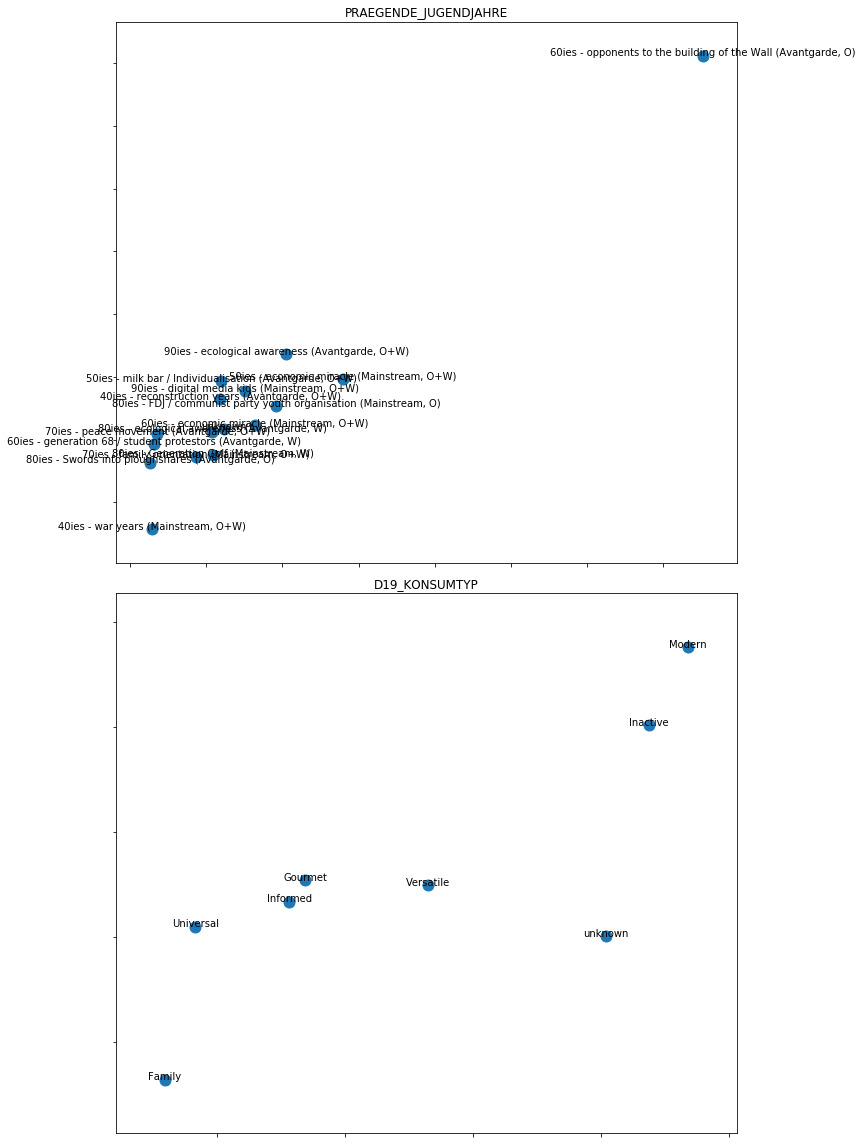

In [33]:
fig, axs = plt.subplots(len(weight_dfs.keys()), 1, figsize=(12,16))
for i, name in enumerate(weight_dfs.keys()):
    axs[i].scatter(weight_dfs[name]['x'], weight_dfs[name]['y'], s=121)
    for cat in weight_dfs[name].index:
        axs[i].text(weight_dfs[name].loc[cat, 'x'], weight_dfs[name].loc[cat, 'y'],
                   cat, ha='center')
    axs[i].set_title(name)
    axs[i].set_xticklabels([])
    axs[i].set_yticklabels([])
fig.tight_layout()    

## Finetune Neural Network with Optuna

In [45]:
import optuna
#from optuna.integration import KerasPruningCallback

from tensorflow.keras.callbacks import Callback

class TFKerasPruningCallback(Callback):

    def __init__(self, trial, monitor):
        # type: (optuna.trial.Trial, str) -> None

        super(TFKerasPruningCallback, self).__init__()

        self.trial = trial
        self.monitor = monitor

    def on_epoch_end(self, epoch, logs=None):
        # type: (int, Dict[str, float]) -> None

        logs = logs or {}
        current_score = logs.get(self.monitor)
        if current_score is None:
            return
        self.trial.report(current_score, step=epoch)
        if self.trial.should_prune():
            message = "Trial was pruned at epoch {}.".format(epoch)
            raise optuna.structs.TrialPruned(message)


In [46]:
def create_model_optuna(trial):
    
    global cat_ord_dict
    
    # ----- embeddings
    input_cat_ord = dict()
    embedding_cat_ord = dict()
    for k, v in cat_ord_dict.items():
        input_cat_ord[k] = layers.Input(shape=(1,), name='input_'+k)
        embedding_cat_ord[k] = layers.Embedding(input_dim=v[0], output_dim=v[1],
                                                name='emb_'+k)(input_cat_ord[k])
        embedding_cat_ord[k] = layers.Flatten(name='emb_flatten_'+k)(embedding_cat_ord[k])
        
    x = layers.Concatenate(name='emb_concatenate')(list(embedding_cat_ord.values()))
    
    # ----- hidden layers
    n_layers = trial.suggest_int('n_layers', 1, 3)
    activation = trial.suggest_categorical('activation', choices=['relu', 'elu'])
    kernel_initializer=trial.suggest_categorical('kernel_initializer',  
                                                 choices=['glorot_uniform', 'glorot_normal'])
    lr_param = int(trial.suggest_loguniform("lr_param", 1e-5, 1e-2))
    for i in range(n_layers):
        n_hidden = int(trial.suggest_loguniform("n_units_l{}".format(i), 4, 32))
        reg_param = int(trial.suggest_loguniform("reg_param_l{}".format(i), 1e-6, 1.0))
        x = layers.Dense(n_hidden, 
                         kernel_initializer=kernel_initializer,
                         activation=activation,
                         kernel_regularizer=regularizers.l1(reg_param),
                         name='dense_'+str(i))(x)

    # ----- final layer
    output = layers.Dense(1, activation='sigmoid', name='output')(x)

    model = models.Model(inputs=list(input_cat_ord.values()), outputs=output)
    model.compile(optimizer=optimizers.Adam(lr_param), loss='binary_crossentropy', metrics=['AUC'])

    return model

In [49]:
def objective(trial):
    # Clear clutter from previous session graphs.
    K.clear_session()

    global cat_ord_dict, mailout, test, responded
    # prepare data
    encoders, input_mailout, input_test = prepare_input(cat_ord_dict, mailout, test)

    # Generate our trial model.
    model = create_model_optuna(trial)

    # Fit the model on the training data.
    # The TFKerasPruningCallback checks for pruning condition every epoch.
    hist = model.fit(x=input_mailout, y=responded.values, class_weight={0:0.01, 1:0.99}, 
                   epochs=4, verbose=0, batch_size=2**7,
                   callbacks=[TFKerasPruningCallback(trial, "val_loss")],
                   validation_split=0.3, shuffle=True) 

    # score is validation loss at last epoch
    score = hist.history['AUC'][-1] # 
    return score

In [50]:
study = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner())
study.optimize(objective, n_trials=1000)

  ...
    to  
  ['...']
  ...
    to  
  ['...']


[I 2020-04-05 19:13:40,593] Finished trial#0 with value: 0.5023140907287598 with parameters: {'n_layers': 3, 'activation': 'elu', 'kernel_initializer': 'glorot_normal', 'lr_param': 0.001117353400559457, 'n_units_l0': 9.289139517553842, 'reg_param_l0': 0.0031214242984330008, 'n_units_l1': 5.185714276819388, 'reg_param_l1': 6.169860119409213e-05, 'n_units_l2': 30.557313722325336, 'reg_param_l2': 0.09616730769085044}. Best is trial#0 with value: 0.5023140907287598.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[I 2020-04-05 19:13:48,669] Finished trial#1 with value: 0.47029000520706177 with parameters: {'n_layers': 3, 'activation': 'relu', 'kernel_initializer': 'glorot_normal', 'lr_param': 2.3748859089266194e-05, 'n_units_l0': 6.893570965708059, 'reg_param_l0': 2.194398363650404e-05, 'n_units_l1': 18.954546101815346, 'reg_param_l1': 0.15407796127213197, 'n_units_l2': 9.502676496405758, 'reg_param_l2': 0.18129754430907463}. Best is trial#0 with value: 0.5023140907287598.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[I 2020-04-05 19:13:56,694] Finished trial#2 with value: 0.5552139282226562 with parameters: {'n_layers': 3, 'activation': 'relu', 'kernel_initializer': 'glorot_uniform', 'lr_param': 0.005293766264264826, 'n_units_l0': 28.81231893656437, 'reg_param_l0': 0.00026060288133668904, 'n_units_l1': 4.337876260697808, 'reg_param_l1': 6.069588063515469e-05, 'n_units_l2': 8.728730165806038, 'reg_param_l2': 0.009046405667658405}. Best is trial#2 with value: 0.5552139282226562.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[I 2020-04-05 19:14:04,521] Finished trial#3 with value: 0.5894232988357544 with parameters: {'n_layers': 1, 'activation': 'elu', 'kernel_initializer': 'glorot_uniform', 'lr_param': 0.008298377899725816, 'n_units_l0': 22.02605910766077, 'reg_param_l0': 2.132627542311934e-06}. Best is trial#3 with value: 0.5894232988357544.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[I 2020-04-05 19:14:12,335] Finished trial#4 with value: 0.5378184914588928 with parameters: {'n_layers': 2, 'activation': 'elu', 'kernel_initializer': 'glorot_normal', 'lr_param': 0.0008225164888494889, 'n_units_l0': 4.704926872685188, 'reg_param_l0': 8.146375223801396e-06, 'n_units_l1': 7.348416407616165, 'reg_param_l1': 4.946473549243937e-06}. Best is trial#3 with value: 0.5894232988357544.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[I 2020-04-05 19:14:20,583] Finished trial#5 with value: 0.35414183139801025 with parameters: {'n_layers': 3, 'activation': 'elu', 'kernel_initializer': 'glorot_uniform', 'lr_param': 3.583118392262384e-05, 'n_units_l0': 16.86955152675272, 'reg_param_l0': 9.064573970012081e-06, 'n_units_l1': 26.728350745528292, 'reg_param_l1': 8.060837257585305e-06, 'n_units_l2': 18.499622218695094, 'reg_param_l2': 0.0035460826881165324}. Best is trial#3 with value: 0.5894232988357544.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[I 2020-04-05 19:14:28,708] Finished trial#6 with value: 0.5070053935050964 with parameters: {'n_layers': 2, 'activation': 'elu', 'kernel_initializer': 'glorot_uniform', 'lr_param': 0.004621477457555528, 'n_units_l0': 4.0410519875779265, 'reg_param_l0': 0.9910724062537646, 'n_units_l1': 26.809393099357965, 'reg_param_l1': 1.9612836636123632e-05}. Best is trial#3 with value: 0.5894232988357544.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[I 2020-04-05 19:14:36,592] Finished trial#7 with value: 0.5502959489822388 with parameters: {'n_layers': 1, 'activation': 'elu', 'kernel_initializer': 'glorot_normal', 'lr_param': 0.0005057550807834043, 'n_units_l0': 30.520625067944977, 'reg_param_l0': 0.0011428384199691386}. Best is trial#3 with value: 0.5894232988357544.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[I 2020-04-05 19:14:44,409] Finished trial#8 with value: 0.4203590750694275 with parameters: {'n_layers': 1, 'activation': 'elu', 'kernel_initializer': 'glorot_normal', 'lr_param': 1.6264666847191025e-05, 'n_units_l0': 7.585888207411929, 'reg_param_l0': 0.0009174776470940919}. Best is trial#3 with value: 0.5894232988357544.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[I 2020-04-05 19:14:52,373] Finished trial#9 with value: 0.4597923159599304 with parameters: {'n_layers': 1, 'activation': 'elu', 'kernel_initializer': 'glorot_uniform', 'lr_param': 0.0020079762611387784, 'n_units_l0': 18.678482802000342, 'reg_param_l0': 0.00013389267647217663}. Best is trial#3 with value: 0.5894232988357544.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:14:57,402] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:14:57,406] Setting status of trial#10 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[I 2020-04-05 19:15:05,588] Finished trial#11 with value: 0.4862314760684967 with parameters: {'n_layers': 2, 'activation': 'relu', 'kernel_initializer': 'glorot_uniform', 'lr_param': 0.007451222512306564, 'n_units_l0': 29.747920007551492, 'reg_param_l0': 1.0619407929401207e-06, 'n_units_l1': 22.33239990588197, 'reg_param_l1': 5.7475153371081495e-05}. Best is trial#3 with value: 0.5894232988357544.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[I 2020-04-05 19:15:13,771] Finished trial#12 with value: 0.4571882486343384 with parameters: {'n_layers': 3, 'activation': 'relu', 'kernel_initializer': 'glorot_uniform', 'lr_param': 0.008864092107421182, 'n_units_l0': 23.536602467150004, 'reg_param_l0': 1.1400682783641126e-06, 'n_units_l1': 5.639906541453714, 'reg_param_l1': 0.0010669056535380014, 'n_units_l2': 5.779314657823846, 'reg_param_l2': 0.00022900673453276707}. Best is trial#3 with value: 0.5894232988357544.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[I 2020-04-05 19:15:22,030] Finished trial#13 with value: 0.43402719497680664 with parameters: {'n_layers': 2, 'activation': 'relu', 'kernel_initializer': 'glorot_uniform', 'lr_param': 0.0030382560323073725, 'n_units_l0': 12.6268002390387, 'reg_param_l0': 0.05611603913596521, 'n_units_l1': 10.166492681529629, 'reg_param_l1': 0.06340107736051574}. Best is trial#3 with value: 0.5894232988357544.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:15:27,208] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:15:27,212] Setting status of trial#14 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[I 2020-04-05 19:15:35,167] Finished trial#15 with value: 0.44031691551208496 with parameters: {'n_layers': 1, 'activation': 'relu', 'kernel_initializer': 'glorot_uniform', 'lr_param': 0.00977522292494045, 'n_units_l0': 23.18987072316881, 'reg_param_l0': 0.008192145493010667}. Best is trial#3 with value: 0.5894232988357544.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:15:40,328] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:15:40,332] Setting status of trial#16 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:15:45,785] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:15:45,788] Setting status of trial#17 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:15:51,188] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:15:51,192] Setting status of trial#18 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:15:56,586] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:15:56,589] Setting status of trial#19 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[I 2020-04-05 19:16:04,740] Finished trial#20 with value: 0.4101288616657257 with parameters: {'n_layers': 2, 'activation': 'elu', 'kernel_initializer': 'glorot_uniform', 'lr_param': 0.009961585216201179, 'n_units_l0': 26.61867283459797, 'reg_param_l0': 0.0009573595482223057, 'n_units_l1': 14.152684846492447, 'reg_param_l1': 3.3223535791322676e-06}. Best is trial#3 with value: 0.5894232988357544.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:16:09,841] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:16:09,843] Setting status of trial#21 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:16:15,188] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:16:15,190] Setting status of trial#22 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:16:20,538] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:16:20,541] Setting status of trial#23 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:16:25,871] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:16:25,874] Setting status of trial#24 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:16:31,171] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:16:31,174] Setting status of trial#25 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:16:36,487] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:16:36,489] Setting status of trial#26 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:16:41,896] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:16:41,899] Setting status of trial#27 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[I 2020-04-05 19:16:50,159] Finished trial#28 with value: 0.42874449491500854 with parameters: {'n_layers': 1, 'activation': 'elu', 'kernel_initializer': 'glorot_uniform', 'lr_param': 0.00030257680465311143, 'n_units_l0': 27.481339286199674, 'reg_param_l0': 0.00040461288634660624}. Best is trial#3 with value: 0.5894232988357544.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:16:55,507] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:16:55,510] Setting status of trial#29 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:17:00,836] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:17:00,839] Setting status of trial#30 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[I 2020-04-05 19:17:09,265] Finished trial#31 with value: 0.4825533330440521 with parameters: {'n_layers': 2, 'activation': 'elu', 'kernel_initializer': 'glorot_normal', 'lr_param': 0.0007335968671563551, 'n_units_l0': 6.29011312729637, 'reg_param_l0': 1.195458561071304e-05, 'n_units_l1': 8.274537821653736, 'reg_param_l1': 1.6995888814343244e-05}. Best is trial#3 with value: 0.5894232988357544.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:17:14,532] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:17:14,534] Setting status of trial#32 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:17:20,104] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:17:20,106] Setting status of trial#33 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:17:25,551] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:17:25,552] Setting status of trial#34 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[I 2020-04-05 19:17:33,635] Finished trial#35 with value: 0.49988704919815063 with parameters: {'n_layers': 1, 'activation': 'elu', 'kernel_initializer': 'glorot_normal', 'lr_param': 0.003260007928622047, 'n_units_l0': 7.281497413090922, 'reg_param_l0': 4.61563850188563e-05}. Best is trial#3 with value: 0.5894232988357544.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:17:38,953] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:17:38,956] Setting status of trial#36 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[I 2020-04-05 19:17:47,104] Finished trial#37 with value: 0.49119287729263306 with parameters: {'n_layers': 1, 'activation': 'elu', 'kernel_initializer': 'glorot_uniform', 'lr_param': 0.0003803938667850544, 'n_units_l0': 8.386866498965771, 'reg_param_l0': 1.2529297294728825e-05}. Best is trial#3 with value: 0.5894232988357544.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:17:52,300] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:17:52,304] Setting status of trial#38 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:17:57,470] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:17:57,474] Setting status of trial#39 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[I 2020-04-05 19:18:05,748] Finished trial#40 with value: 0.43765395879745483 with parameters: {'n_layers': 2, 'activation': 'elu', 'kernel_initializer': 'glorot_uniform', 'lr_param': 0.0024551108763549976, 'n_units_l0': 4.378873420272562, 'reg_param_l0': 1.876834003233593e-06, 'n_units_l1': 4.685918783450202, 'reg_param_l1': 5.796994810988262e-06}. Best is trial#3 with value: 0.5894232988357544.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:18:10,994] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:18:10,997] Setting status of trial#41 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:18:16,382] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:18:16,385] Setting status of trial#42 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:18:21,821] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:18:21,824] Setting status of trial#43 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:18:27,072] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:18:27,075] Setting status of trial#44 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:18:32,443] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:18:32,446] Setting status of trial#45 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:18:37,865] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:18:37,868] Setting status of trial#46 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:18:43,335] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:18:43,337] Setting status of trial#47 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:18:48,655] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:18:48,657] Setting status of trial#48 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[I 2020-04-05 19:18:57,220] Finished trial#49 with value: 0.49542155861854553 with parameters: {'n_layers': 3, 'activation': 'elu', 'kernel_initializer': 'glorot_uniform', 'lr_param': 0.0016479269612490414, 'n_units_l0': 18.325669926183195, 'reg_param_l0': 0.00015236271571184414, 'n_units_l1': 5.259362446009511, 'reg_param_l1': 1.3079477703149085e-05, 'n_units_l2': 12.26471362943918, 'reg_param_l2': 0.7094032897293153}. Best is trial#3 with value: 0.5894232988357544.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:19:02,429] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:19:02,432] Setting status of trial#50 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:19:07,875] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:19:07,878] Setting status of trial#51 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:19:13,322] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:19:13,325] Setting status of trial#52 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:19:18,679] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:19:18,681] Setting status of trial#53 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:19:24,300] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:19:24,304] Setting status of trial#54 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:19:29,685] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:19:29,687] Setting status of trial#55 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[I 2020-04-05 19:19:37,889] Finished trial#56 with value: 0.4931171238422394 with parameters: {'n_layers': 1, 'activation': 'elu', 'kernel_initializer': 'glorot_normal', 'lr_param': 0.001029104694003159, 'n_units_l0': 9.718478149813553, 'reg_param_l0': 7.157503373904052e-05}. Best is trial#3 with value: 0.5894232988357544.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:19:43,329] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:19:43,332] Setting status of trial#57 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:19:48,831] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:19:48,834] Setting status of trial#58 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[I 2020-04-05 19:19:57,057] Finished trial#59 with value: 0.5645023584365845 with parameters: {'n_layers': 1, 'activation': 'relu', 'kernel_initializer': 'glorot_uniform', 'lr_param': 0.00023454820584551943, 'n_units_l0': 6.683840820065072, 'reg_param_l0': 0.0015651743467397928}. Best is trial#3 with value: 0.5894232988357544.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:20:02,142] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:20:02,146] Setting status of trial#60 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:20:07,505] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:20:07,508] Setting status of trial#61 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:20:12,876] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:20:12,879] Setting status of trial#62 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:20:18,135] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:20:18,138] Setting status of trial#63 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:20:23,390] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:20:23,394] Setting status of trial#64 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:20:28,630] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:20:28,634] Setting status of trial#65 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:20:33,865] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:20:33,868] Setting status of trial#66 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:20:39,025] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:20:39,028] Setting status of trial#67 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:20:44,182] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:20:44,186] Setting status of trial#68 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:20:49,591] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:20:49,595] Setting status of trial#69 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:20:54,963] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:20:54,965] Setting status of trial#70 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:21:00,304] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:21:00,308] Setting status of trial#71 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:21:05,722] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:21:05,726] Setting status of trial#72 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[I 2020-04-05 19:21:13,814] Finished trial#73 with value: 0.4458730220794678 with parameters: {'n_layers': 1, 'activation': 'elu', 'kernel_initializer': 'glorot_normal', 'lr_param': 0.003964033180241405, 'n_units_l0': 8.995868068755279, 'reg_param_l0': 4.4497253479527215e-05}. Best is trial#3 with value: 0.5894232988357544.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:21:18,947] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:21:18,951] Setting status of trial#74 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[I 2020-04-05 19:21:27,066] Finished trial#75 with value: 0.4694496989250183 with parameters: {'n_layers': 1, 'activation': 'elu', 'kernel_initializer': 'glorot_normal', 'lr_param': 0.0028688404427753985, 'n_units_l0': 29.88647208835084, 'reg_param_l0': 1.9141170849939586e-06}. Best is trial#3 with value: 0.5894232988357544.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:21:32,222] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:21:32,225] Setting status of trial#76 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[I 2020-04-05 19:21:40,499] Finished trial#77 with value: 0.465057909488678 with parameters: {'n_layers': 1, 'activation': 'elu', 'kernel_initializer': 'glorot_normal', 'lr_param': 0.0009117394509710002, 'n_units_l0': 9.574060451225733, 'reg_param_l0': 4.776717097797042e-06}. Best is trial#3 with value: 0.5894232988357544.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:21:45,641] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:21:45,644] Setting status of trial#78 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:21:50,893] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:21:50,898] Setting status of trial#79 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[I 2020-04-05 19:21:59,186] Finished trial#80 with value: 0.3954668939113617 with parameters: {'n_layers': 2, 'activation': 'elu', 'kernel_initializer': 'glorot_normal', 'lr_param': 0.0021656831658151488, 'n_units_l0': 6.856444258764022, 'reg_param_l0': 1.240299250596782e-06, 'n_units_l1': 5.017330344852773, 'reg_param_l1': 1.4545026081918764e-05}. Best is trial#3 with value: 0.5894232988357544.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:22:04,507] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:22:04,510] Setting status of trial#81 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:22:09,960] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:22:09,964] Setting status of trial#82 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:22:15,626] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:22:15,628] Setting status of trial#83 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:22:21,160] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:22:21,163] Setting status of trial#84 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:22:26,779] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:22:26,782] Setting status of trial#85 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:22:32,437] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:22:32,440] Setting status of trial#86 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:22:38,187] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:22:38,191] Setting status of trial#87 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:22:43,790] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:22:43,793] Setting status of trial#88 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:22:49,433] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:22:49,435] Setting status of trial#89 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:22:54,850] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:22:54,852] Setting status of trial#90 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:23:00,291] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:23:00,292] Setting status of trial#91 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:23:05,698] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:23:05,702] Setting status of trial#92 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:23:11,026] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:23:11,030] Setting status of trial#93 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[I 2020-04-05 19:23:19,388] Finished trial#94 with value: 0.4121987819671631 with parameters: {'n_layers': 1, 'activation': 'elu', 'kernel_initializer': 'glorot_normal', 'lr_param': 0.0010292554772573452, 'n_units_l0': 22.375903581805584, 'reg_param_l0': 2.4973254036505156e-05}. Best is trial#3 with value: 0.5894232988357544.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:23:24,471] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:23:24,474] Setting status of trial#95 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:23:29,780] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:23:29,783] Setting status of trial#96 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:23:35,229] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:23:35,232] Setting status of trial#97 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:23:40,842] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:23:40,845] Setting status of trial#98 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:23:46,137] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:23:46,140] Setting status of trial#99 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:23:51,528] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:23:51,532] Setting status of trial#100 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:23:56,757] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:23:56,760] Setting status of trial#101 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:24:02,129] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:24:02,133] Setting status of trial#102 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:24:07,506] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:24:07,509] Setting status of trial#103 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:24:12,806] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:24:12,810] Setting status of trial#104 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:24:18,013] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:24:18,016] Setting status of trial#105 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:24:23,354] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:24:23,358] Setting status of trial#106 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:24:28,692] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:24:28,695] Setting status of trial#107 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:24:33,950] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:24:33,953] Setting status of trial#108 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[I 2020-04-05 19:24:42,542] Finished trial#109 with value: 0.44921034574508667 with parameters: {'n_layers': 3, 'activation': 'elu', 'kernel_initializer': 'glorot_uniform', 'lr_param': 0.00028730279626586945, 'n_units_l0': 9.230151285496142, 'reg_param_l0': 2.3616298608182693e-06, 'n_units_l1': 17.67948400050563, 'reg_param_l1': 3.859970039620766e-06, 'n_units_l2': 5.125091221236223, 'reg_param_l2': 0.162707059905079}. Best is trial#3 with value: 0.5894232988357544.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:24:47,659] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:24:47,663] Setting status of trial#110 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[I 2020-04-05 19:24:56,066] Finished trial#111 with value: 0.4825051426887512 with parameters: {'n_layers': 2, 'activation': 'relu', 'kernel_initializer': 'glorot_uniform', 'lr_param': 0.008087944515617007, 'n_units_l0': 27.982773757487983, 'reg_param_l0': 0.00031614782526414936, 'n_units_l1': 21.40297240283101, 'reg_param_l1': 0.015367747731771979}. Best is trial#3 with value: 0.5894232988357544.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:25:01,257] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:25:01,260] Setting status of trial#112 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:25:06,626] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:25:06,628] Setting status of trial#113 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:25:12,205] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:25:12,207] Setting status of trial#114 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:25:17,632] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:25:17,635] Setting status of trial#115 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:25:23,202] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:25:23,204] Setting status of trial#116 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:25:28,593] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:25:28,595] Setting status of trial#117 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:25:33,960] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:25:33,962] Setting status of trial#118 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:25:39,264] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:25:39,267] Setting status of trial#119 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:25:44,612] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:25:44,616] Setting status of trial#120 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:25:49,898] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:25:49,901] Setting status of trial#121 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:25:55,397] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:25:55,400] Setting status of trial#122 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:26:00,925] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:26:00,928] Setting status of trial#123 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:26:06,374] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:26:06,377] Setting status of trial#124 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:26:11,710] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:26:11,713] Setting status of trial#125 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:26:17,108] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:26:17,111] Setting status of trial#126 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:26:22,459] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:26:22,462] Setting status of trial#127 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:26:27,811] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:26:27,814] Setting status of trial#128 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:26:33,322] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:26:33,326] Setting status of trial#129 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:26:38,698] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:26:38,701] Setting status of trial#130 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:26:44,135] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:26:44,138] Setting status of trial#131 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:26:49,323] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:26:49,326] Setting status of trial#132 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:26:54,644] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:26:54,648] Setting status of trial#133 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:26:59,929] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:26:59,933] Setting status of trial#134 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:27:05,297] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:27:05,300] Setting status of trial#135 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:27:10,712] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:27:10,715] Setting status of trial#136 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:27:16,040] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:27:16,044] Setting status of trial#137 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[I 2020-04-05 19:27:24,317] Finished trial#138 with value: 0.4354361891746521 with parameters: {'n_layers': 2, 'activation': 'elu', 'kernel_initializer': 'glorot_normal', 'lr_param': 0.0030990214052616536, 'n_units_l0': 25.03852225128168, 'reg_param_l0': 0.00014473828897031664, 'n_units_l1': 18.387840150234258, 'reg_param_l1': 0.05188835343474181}. Best is trial#3 with value: 0.5894232988357544.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[I 2020-04-05 19:27:32,091] Finished trial#139 with value: 0.47683185338974 with parameters: {'n_layers': 1, 'activation': 'elu', 'kernel_initializer': 'glorot_uniform', 'lr_param': 0.0002093518270999891, 'n_units_l0': 5.865585336813697, 'reg_param_l0': 0.6510924006671357}. Best is trial#3 with value: 0.5894232988357544.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:27:37,479] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:27:37,483] Setting status of trial#140 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:27:42,799] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:27:42,802] Setting status of trial#141 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[I 2020-04-05 19:27:50,958] Finished trial#142 with value: 0.4432562291622162 with parameters: {'n_layers': 1, 'activation': 'elu', 'kernel_initializer': 'glorot_uniform', 'lr_param': 0.0001698809615698028, 'n_units_l0': 5.633713275507364, 'reg_param_l0': 0.2876660269539365}. Best is trial#3 with value: 0.5894232988357544.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[I 2020-04-05 19:27:58,788] Finished trial#143 with value: 0.39897066354751587 with parameters: {'n_layers': 1, 'activation': 'elu', 'kernel_initializer': 'glorot_uniform', 'lr_param': 0.004506884407324339, 'n_units_l0': 6.947308214024052, 'reg_param_l0': 0.00010574611165930725}. Best is trial#3 with value: 0.5894232988357544.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:28:03,819] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:28:03,822] Setting status of trial#144 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:28:08,987] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:28:08,990] Setting status of trial#145 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:28:14,108] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:28:14,111] Setting status of trial#146 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:28:19,474] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:28:19,477] Setting status of trial#147 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:28:24,894] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:28:24,897] Setting status of trial#148 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[I 2020-04-05 19:28:33,399] Finished trial#149 with value: 0.4480511546134949 with parameters: {'n_layers': 3, 'activation': 'elu', 'kernel_initializer': 'glorot_normal', 'lr_param': 0.0006188145149009633, 'n_units_l0': 7.392893824915593, 'reg_param_l0': 0.4209976176080561, 'n_units_l1': 22.582429381035272, 'reg_param_l1': 0.013451423553504302, 'n_units_l2': 6.409380151658664, 'reg_param_l2': 0.007806144650811846}. Best is trial#3 with value: 0.5894232988357544.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:28:38,538] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:28:38,541] Setting status of trial#150 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:28:43,985] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:28:43,988] Setting status of trial#151 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:28:49,359] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:28:49,362] Setting status of trial#152 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:28:54,787] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:28:54,790] Setting status of trial#153 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:29:00,227] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:29:00,230] Setting status of trial#154 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:29:05,780] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:29:05,784] Setting status of trial#155 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:29:11,128] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:29:11,131] Setting status of trial#156 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:29:16,666] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:29:16,670] Setting status of trial#157 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:29:21,911] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:29:21,915] Setting status of trial#158 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:29:27,149] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:29:27,152] Setting status of trial#159 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:29:32,342] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:29:32,343] Setting status of trial#160 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[I 2020-04-05 19:29:40,605] Finished trial#161 with value: 0.4547889828681946 with parameters: {'n_layers': 1, 'activation': 'elu', 'kernel_initializer': 'glorot_normal', 'lr_param': 0.0031935739879475787, 'n_units_l0': 26.09894031123857, 'reg_param_l0': 2.178378013875122e-06}. Best is trial#3 with value: 0.5894232988357544.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[I 2020-04-05 19:29:48,760] Finished trial#162 with value: 0.42879271507263184 with parameters: {'n_layers': 1, 'activation': 'elu', 'kernel_initializer': 'glorot_normal', 'lr_param': 0.00494896009203654, 'n_units_l0': 30.08585874005301, 'reg_param_l0': 1.6721214211459278e-06}. Best is trial#3 with value: 0.5894232988357544.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:29:53,895] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:29:53,899] Setting status of trial#163 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:29:59,228] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:29:59,232] Setting status of trial#164 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:30:04,625] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:30:04,627] Setting status of trial#165 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:30:10,351] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:30:10,355] Setting status of trial#166 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:30:15,664] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:30:15,668] Setting status of trial#167 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:30:21,068] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:30:21,071] Setting status of trial#168 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:30:26,251] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:30:26,254] Setting status of trial#169 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:30:31,641] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:30:31,644] Setting status of trial#170 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:30:37,034] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:30:37,037] Setting status of trial#171 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[I 2020-04-05 19:30:45,276] Finished trial#172 with value: 0.45904549956321716 with parameters: {'n_layers': 1, 'activation': 'elu', 'kernel_initializer': 'glorot_normal', 'lr_param': 0.0011368711168052309, 'n_units_l0': 9.806915811520707, 'reg_param_l0': 1.1118687869136567e-05}. Best is trial#3 with value: 0.5894232988357544.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:30:50,383] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:30:50,387] Setting status of trial#173 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:30:55,808] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:30:55,811] Setting status of trial#174 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:31:01,300] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:31:01,303] Setting status of trial#175 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:31:06,705] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:31:06,707] Setting status of trial#176 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:31:12,041] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:31:12,043] Setting status of trial#177 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[I 2020-04-05 19:31:20,343] Finished trial#178 with value: 0.49343836307525635 with parameters: {'n_layers': 2, 'activation': 'elu', 'kernel_initializer': 'glorot_uniform', 'lr_param': 0.0022392118258587126, 'n_units_l0': 8.25913160534537, 'reg_param_l0': 1.685832455682981e-05, 'n_units_l1': 4.668111002926479, 'reg_param_l1': 0.005763357164254193}. Best is trial#3 with value: 0.5894232988357544.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:31:25,510] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:31:25,512] Setting status of trial#179 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:31:30,936] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:31:30,940] Setting status of trial#180 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:31:36,341] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:31:36,345] Setting status of trial#181 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:31:41,695] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:31:41,698] Setting status of trial#182 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:31:47,103] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:31:47,105] Setting status of trial#183 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:31:52,431] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:31:52,433] Setting status of trial#184 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:31:57,812] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:31:57,815] Setting status of trial#185 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[I 2020-04-05 19:32:05,960] Finished trial#186 with value: 0.4318732023239136 with parameters: {'n_layers': 1, 'activation': 'elu', 'kernel_initializer': 'glorot_uniform', 'lr_param': 0.000991950152643982, 'n_units_l0': 8.424668068939841, 'reg_param_l0': 5.12231517276818e-06}. Best is trial#3 with value: 0.5894232988357544.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:32:11,051] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:32:11,054] Setting status of trial#187 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:32:16,360] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:32:16,362] Setting status of trial#188 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:32:21,713] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:32:21,716] Setting status of trial#189 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[I 2020-04-05 19:32:29,753] Finished trial#190 with value: 0.4493390619754791 with parameters: {'n_layers': 1, 'activation': 'elu', 'kernel_initializer': 'glorot_normal', 'lr_param': 0.003500744141354247, 'n_units_l0': 4.207932157616998, 'reg_param_l0': 5.445938133204467e-05}. Best is trial#3 with value: 0.5894232988357544.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:32:34,913] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:32:34,915] Setting status of trial#191 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:32:40,277] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:32:40,280] Setting status of trial#192 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:32:45,667] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:32:45,671] Setting status of trial#193 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:32:51,038] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:32:51,041] Setting status of trial#194 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:32:56,595] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:32:56,599] Setting status of trial#195 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:33:02,072] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:33:02,075] Setting status of trial#196 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:33:07,467] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:33:07,469] Setting status of trial#197 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:33:12,823] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:33:12,826] Setting status of trial#198 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:33:18,315] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:33:18,319] Setting status of trial#199 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:33:23,732] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:33:23,735] Setting status of trial#200 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:33:29,117] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:33:29,119] Setting status of trial#201 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:33:34,474] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:33:34,477] Setting status of trial#202 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:33:39,855] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:33:39,858] Setting status of trial#203 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:33:45,214] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:33:45,217] Setting status of trial#204 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[I 2020-04-05 19:33:53,445] Finished trial#205 with value: 0.4607086181640625 with parameters: {'n_layers': 1, 'activation': 'elu', 'kernel_initializer': 'glorot_normal', 'lr_param': 0.0027168122131987784, 'n_units_l0': 18.48191497676149, 'reg_param_l0': 2.4102871822576863e-05}. Best is trial#3 with value: 0.5894232988357544.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:33:58,648] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:33:58,651] Setting status of trial#206 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:34:03,983] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:34:03,986] Setting status of trial#207 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:34:09,639] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:34:09,643] Setting status of trial#208 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:34:14,960] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:34:14,963] Setting status of trial#209 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[I 2020-04-05 19:34:23,440] Finished trial#210 with value: 0.4828142523765564 with parameters: {'n_layers': 1, 'activation': 'elu', 'kernel_initializer': 'glorot_uniform', 'lr_param': 0.0020857173972871645, 'n_units_l0': 29.128379727111444, 'reg_param_l0': 0.00012607741260311023}. Best is trial#3 with value: 0.5894232988357544.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:34:28,659] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:34:28,662] Setting status of trial#211 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:34:34,086] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:34:34,089] Setting status of trial#212 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:34:39,518] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:34:39,521] Setting status of trial#213 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[I 2020-04-05 19:34:47,845] Finished trial#214 with value: 0.45299941301345825 with parameters: {'n_layers': 1, 'activation': 'elu', 'kernel_initializer': 'glorot_uniform', 'lr_param': 0.00178904971084269, 'n_units_l0': 29.596773896725065, 'reg_param_l0': 6.821396251223833e-05}. Best is trial#3 with value: 0.5894232988357544.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:34:53,013] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:34:53,017] Setting status of trial#215 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[I 2020-04-05 19:35:01,204] Finished trial#216 with value: 0.43943727016448975 with parameters: {'n_layers': 1, 'activation': 'elu', 'kernel_initializer': 'glorot_uniform', 'lr_param': 0.006719892352542228, 'n_units_l0': 28.18715888540116, 'reg_param_l0': 1.564843110682338e-05}. Best is trial#3 with value: 0.5894232988357544.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:35:06,513] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:35:06,517] Setting status of trial#217 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:35:11,718] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:35:11,722] Setting status of trial#218 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:35:17,296] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:35:17,300] Setting status of trial#219 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:35:22,811] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:35:22,815] Setting status of trial#220 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[I 2020-04-05 19:35:31,098] Finished trial#221 with value: 0.44347116351127625 with parameters: {'n_layers': 1, 'activation': 'elu', 'kernel_initializer': 'glorot_normal', 'lr_param': 0.0010233986886686816, 'n_units_l0': 9.031398260984163, 'reg_param_l0': 1.3282322662433933e-05}. Best is trial#3 with value: 0.5894232988357544.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:35:36,124] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:35:36,127] Setting status of trial#222 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:35:41,465] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:35:41,468] Setting status of trial#223 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:35:46,909] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:35:46,912] Setting status of trial#224 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:35:52,298] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:35:52,302] Setting status of trial#225 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[I 2020-04-05 19:36:00,492] Finished trial#226 with value: 0.4368351697921753 with parameters: {'n_layers': 1, 'activation': 'elu', 'kernel_initializer': 'glorot_normal', 'lr_param': 0.0024229757181632, 'n_units_l0': 6.457539013610001, 'reg_param_l0': 1.8075326941659132e-05}. Best is trial#3 with value: 0.5894232988357544.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:36:05,795] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:36:05,798] Setting status of trial#227 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:36:11,174] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:36:11,177] Setting status of trial#228 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:36:16,497] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:36:16,500] Setting status of trial#229 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:36:22,090] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:36:22,093] Setting status of trial#230 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:36:27,502] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:36:27,505] Setting status of trial#231 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:36:33,092] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:36:33,095] Setting status of trial#232 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:36:38,623] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:36:38,626] Setting status of trial#233 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:36:44,249] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:36:44,253] Setting status of trial#234 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:36:49,692] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:36:49,696] Setting status of trial#235 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:36:55,416] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:36:55,418] Setting status of trial#236 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:37:00,876] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:37:00,878] Setting status of trial#237 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:37:06,125] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:37:06,128] Setting status of trial#238 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:37:11,434] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:37:11,437] Setting status of trial#239 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:37:16,746] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:37:16,749] Setting status of trial#240 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:37:22,134] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:37:22,136] Setting status of trial#241 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:37:27,591] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:37:27,593] Setting status of trial#242 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:37:33,002] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:37:33,004] Setting status of trial#243 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:37:38,417] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:37:38,420] Setting status of trial#244 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:37:43,780] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:37:43,783] Setting status of trial#245 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:37:49,135] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:37:49,138] Setting status of trial#246 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:37:54,707] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:37:54,710] Setting status of trial#247 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:38:00,071] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:38:00,074] Setting status of trial#248 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[I 2020-04-05 19:38:08,473] Finished trial#249 with value: 0.4343593716621399 with parameters: {'n_layers': 1, 'activation': 'elu', 'kernel_initializer': 'glorot_uniform', 'lr_param': 0.0020217432333480495, 'n_units_l0': 24.509805726232123, 'reg_param_l0': 0.00015444733270980705}. Best is trial#3 with value: 0.5894232988357544.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:38:13,589] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:38:13,592] Setting status of trial#250 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:38:19,051] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:38:19,054] Setting status of trial#251 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:38:24,665] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:38:24,668] Setting status of trial#252 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:38:30,287] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:38:30,290] Setting status of trial#253 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:38:35,633] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:38:35,635] Setting status of trial#254 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:38:41,169] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:38:41,173] Setting status of trial#255 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:38:46,590] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:38:46,592] Setting status of trial#256 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:38:52,284] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:38:52,286] Setting status of trial#257 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[I 2020-04-05 19:39:00,381] Finished trial#258 with value: 0.3541531264781952 with parameters: {'n_layers': 1, 'activation': 'relu', 'kernel_initializer': 'glorot_normal', 'lr_param': 0.00572662013904667, 'n_units_l0': 6.654288820996577, 'reg_param_l0': 0.0006101039939112569}. Best is trial#3 with value: 0.5894232988357544.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:39:05,470] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:39:05,472] Setting status of trial#259 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:39:10,970] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:39:10,974] Setting status of trial#260 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:39:16,263] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:39:16,266] Setting status of trial#261 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:39:21,832] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:39:21,834] Setting status of trial#262 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:39:27,514] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:39:27,517] Setting status of trial#263 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:39:32,880] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:39:32,884] Setting status of trial#264 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:39:38,297] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:39:38,299] Setting status of trial#265 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:39:43,801] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:39:43,805] Setting status of trial#266 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:39:49,177] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:39:49,181] Setting status of trial#267 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:39:54,647] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:39:54,651] Setting status of trial#268 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:40:00,081] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:40:00,084] Setting status of trial#269 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:40:05,464] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:40:05,467] Setting status of trial#270 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:40:10,981] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:40:10,984] Setting status of trial#271 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:40:16,192] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:40:16,195] Setting status of trial#272 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[I 2020-04-05 19:40:24,551] Finished trial#273 with value: 0.4342511296272278 with parameters: {'n_layers': 3, 'activation': 'elu', 'kernel_initializer': 'glorot_normal', 'lr_param': 0.002477730077325939, 'n_units_l0': 7.398787718854422, 'reg_param_l0': 8.896371493794832e-06, 'n_units_l1': 4.634464564300464, 'reg_param_l1': 0.03297156933663564, 'n_units_l2': 8.297767433444303, 'reg_param_l2': 0.0004984596011775143}. Best is trial#3 with value: 0.5894232988357544.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:40:29,675] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:40:29,679] Setting status of trial#274 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:40:35,165] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:40:35,168] Setting status of trial#275 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:40:40,550] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:40:40,553] Setting status of trial#276 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:40:45,938] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:40:45,941] Setting status of trial#277 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:40:51,418] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:40:51,421] Setting status of trial#278 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:40:56,949] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:40:56,953] Setting status of trial#279 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:41:02,184] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:41:02,187] Setting status of trial#280 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:41:07,516] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:41:07,519] Setting status of trial#281 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:41:13,207] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:41:13,210] Setting status of trial#282 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[I 2020-04-05 19:41:21,459] Finished trial#283 with value: 0.4167872369289398 with parameters: {'n_layers': 1, 'activation': 'elu', 'kernel_initializer': 'glorot_normal', 'lr_param': 0.0003954933803682513, 'n_units_l0': 23.57563971643265, 'reg_param_l0': 1.3133262473090623e-05}. Best is trial#3 with value: 0.5894232988357544.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:41:26,618] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:41:26,622] Setting status of trial#284 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:41:32,025] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:41:32,028] Setting status of trial#285 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:41:37,483] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:41:37,487] Setting status of trial#286 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:41:43,108] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:41:43,111] Setting status of trial#287 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[I 2020-04-05 19:41:51,399] Finished trial#288 with value: 0.49094346165657043 with parameters: {'n_layers': 1, 'activation': 'elu', 'kernel_initializer': 'glorot_normal', 'lr_param': 0.002900248305386458, 'n_units_l0': 29.26412251922432, 'reg_param_l0': 7.949314450587548e-05}. Best is trial#3 with value: 0.5894232988357544.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:41:56,642] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:41:56,646] Setting status of trial#289 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[I 2020-04-05 19:42:04,877] Finished trial#290 with value: 0.4648558497428894 with parameters: {'n_layers': 1, 'activation': 'elu', 'kernel_initializer': 'glorot_uniform', 'lr_param': 0.007791558210613884, 'n_units_l0': 8.539824405341221, 'reg_param_l0': 8.730755694939059e-05}. Best is trial#3 with value: 0.5894232988357544.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:42:10,069] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:42:10,073] Setting status of trial#291 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:42:15,498] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:42:15,500] Setting status of trial#292 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:42:20,940] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:42:20,943] Setting status of trial#293 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:42:26,302] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:42:26,304] Setting status of trial#294 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:42:31,725] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:42:31,728] Setting status of trial#295 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:42:37,140] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:42:37,143] Setting status of trial#296 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:42:42,340] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:42:42,343] Setting status of trial#297 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:42:47,730] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:42:47,733] Setting status of trial#298 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:42:53,307] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:42:53,309] Setting status of trial#299 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:42:58,706] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:42:58,709] Setting status of trial#300 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:43:04,072] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:43:04,075] Setting status of trial#301 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:43:09,599] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:43:09,602] Setting status of trial#302 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:43:15,044] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:43:15,047] Setting status of trial#303 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:43:20,449] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:43:20,452] Setting status of trial#304 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:43:26,042] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:43:26,045] Setting status of trial#305 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:43:31,298] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:43:31,301] Setting status of trial#306 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:43:36,528] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:43:36,532] Setting status of trial#307 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:43:42,006] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:43:42,010] Setting status of trial#308 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:43:47,311] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:43:47,315] Setting status of trial#309 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:43:52,777] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:43:52,780] Setting status of trial#310 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:43:58,194] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:43:58,197] Setting status of trial#311 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:44:03,642] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:44:03,646] Setting status of trial#312 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:44:09,043] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:44:09,047] Setting status of trial#313 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:44:14,481] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:44:14,485] Setting status of trial#314 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:44:19,968] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:44:19,971] Setting status of trial#315 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:44:25,395] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:44:25,398] Setting status of trial#316 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:44:30,799] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:44:30,802] Setting status of trial#317 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:44:36,363] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:44:36,366] Setting status of trial#318 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:44:41,615] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:44:41,618] Setting status of trial#319 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:44:46,971] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:44:46,973] Setting status of trial#320 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:44:52,287] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:44:52,289] Setting status of trial#321 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:44:57,707] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:44:57,710] Setting status of trial#322 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:45:03,293] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:45:03,295] Setting status of trial#323 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:45:08,713] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:45:08,716] Setting status of trial#324 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:45:14,083] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:45:14,085] Setting status of trial#325 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:45:19,599] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:45:19,601] Setting status of trial#326 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:45:24,982] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:45:24,984] Setting status of trial#327 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:45:30,228] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:45:30,231] Setting status of trial#328 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:45:35,846] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:45:35,849] Setting status of trial#329 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:45:41,328] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:45:41,331] Setting status of trial#330 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:45:46,915] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:45:46,918] Setting status of trial#331 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:45:52,456] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:45:52,459] Setting status of trial#332 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:45:58,124] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:45:58,127] Setting status of trial#333 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:46:03,568] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:46:03,570] Setting status of trial#334 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:46:08,915] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:46:08,917] Setting status of trial#335 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[I 2020-04-05 19:46:17,053] Finished trial#336 with value: 0.42940714955329895 with parameters: {'n_layers': 1, 'activation': 'elu', 'kernel_initializer': 'glorot_normal', 'lr_param': 0.006133052898865348, 'n_units_l0': 12.455428269965864, 'reg_param_l0': 0.00012080340111695626}. Best is trial#3 with value: 0.5894232988357544.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:46:22,062] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:46:22,065] Setting status of trial#337 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:46:27,612] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:46:27,615] Setting status of trial#338 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:46:32,890] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:46:32,894] Setting status of trial#339 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:46:38,174] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:46:38,176] Setting status of trial#340 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:46:43,757] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:46:43,761] Setting status of trial#341 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:46:49,206] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:46:49,210] Setting status of trial#342 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[I 2020-04-05 19:46:57,237] Finished trial#343 with value: 0.4137366712093353 with parameters: {'n_layers': 1, 'activation': 'elu', 'kernel_initializer': 'glorot_uniform', 'lr_param': 0.0018112014346060284, 'n_units_l0': 9.20992330500049, 'reg_param_l0': 2.3910812292196596e-05}. Best is trial#3 with value: 0.5894232988357544.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:47:02,447] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:47:02,451] Setting status of trial#344 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:47:07,863] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:47:07,865] Setting status of trial#345 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:47:13,514] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:47:13,517] Setting status of trial#346 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:47:18,847] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:47:18,850] Setting status of trial#347 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:47:24,315] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:47:24,318] Setting status of trial#348 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:47:29,740] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:47:29,743] Setting status of trial#349 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:47:35,054] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:47:35,057] Setting status of trial#350 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:47:40,520] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:47:40,523] Setting status of trial#351 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:47:45,928] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:47:45,932] Setting status of trial#352 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:47:51,458] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:47:51,462] Setting status of trial#353 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:47:57,007] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:47:57,010] Setting status of trial#354 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:48:02,481] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:48:02,485] Setting status of trial#355 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:48:08,085] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:48:08,089] Setting status of trial#356 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:48:13,489] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:48:13,492] Setting status of trial#357 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:48:18,934] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:48:18,937] Setting status of trial#358 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:48:24,295] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:48:24,298] Setting status of trial#359 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:48:29,645] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:48:29,649] Setting status of trial#360 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:48:35,108] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:48:35,111] Setting status of trial#361 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:48:40,481] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:48:40,484] Setting status of trial#362 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:48:46,002] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:48:46,005] Setting status of trial#363 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:48:51,288] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:48:51,290] Setting status of trial#364 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:48:56,742] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:48:56,745] Setting status of trial#365 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:49:02,255] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:49:02,258] Setting status of trial#366 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:49:07,784] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:49:07,789] Setting status of trial#367 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:49:13,111] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:49:13,115] Setting status of trial#368 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:49:18,354] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:49:18,357] Setting status of trial#369 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:49:23,622] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:49:23,625] Setting status of trial#370 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:49:28,940] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:49:28,943] Setting status of trial#371 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:49:34,389] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:49:34,392] Setting status of trial#372 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:49:39,926] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:49:39,929] Setting status of trial#373 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:49:45,381] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:49:45,384] Setting status of trial#374 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:49:50,780] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:49:50,784] Setting status of trial#375 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[I 2020-04-05 19:49:59,210] Finished trial#376 with value: 0.4530490040779114 with parameters: {'n_layers': 2, 'activation': 'elu', 'kernel_initializer': 'glorot_uniform', 'lr_param': 0.0017306213332381384, 'n_units_l0': 7.932997096959544, 'reg_param_l0': 0.0001052927700343296, 'n_units_l1': 19.28028709765878, 'reg_param_l1': 3.989620709340785e-05}. Best is trial#3 with value: 0.5894232988357544.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:50:04,333] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:50:04,336] Setting status of trial#377 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:50:09,733] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:50:09,736] Setting status of trial#378 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:50:15,144] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:50:15,148] Setting status of trial#379 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:50:20,654] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:50:20,657] Setting status of trial#380 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:50:26,366] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:50:26,369] Setting status of trial#381 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:50:31,872] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:50:31,875] Setting status of trial#382 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:50:37,274] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:50:37,277] Setting status of trial#383 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:50:42,613] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:50:42,616] Setting status of trial#384 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:50:47,972] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:50:47,975] Setting status of trial#385 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:50:53,118] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:50:53,121] Setting status of trial#386 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:50:58,480] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:50:58,483] Setting status of trial#387 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:51:03,792] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:51:03,795] Setting status of trial#388 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:51:09,178] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:51:09,181] Setting status of trial#389 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:51:14,625] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:51:14,627] Setting status of trial#390 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:51:20,376] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:51:20,379] Setting status of trial#391 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:51:25,668] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:51:25,671] Setting status of trial#392 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:51:31,177] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:51:31,180] Setting status of trial#393 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:51:36,583] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:51:36,586] Setting status of trial#394 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:51:42,021] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:51:42,025] Setting status of trial#395 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:51:47,416] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:51:47,420] Setting status of trial#396 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:51:52,918] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:51:52,921] Setting status of trial#397 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:51:58,488] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:51:58,492] Setting status of trial#398 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:52:03,820] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:52:03,824] Setting status of trial#399 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:52:09,317] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:52:09,321] Setting status of trial#400 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:52:14,759] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:52:14,762] Setting status of trial#401 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:52:20,151] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:52:20,154] Setting status of trial#402 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:52:25,806] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:52:25,809] Setting status of trial#403 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:52:31,468] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:52:31,472] Setting status of trial#404 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:52:36,922] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:52:36,925] Setting status of trial#405 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[I 2020-04-05 19:52:45,113] Finished trial#406 with value: 0.46829262375831604 with parameters: {'n_layers': 1, 'activation': 'elu', 'kernel_initializer': 'glorot_normal', 'lr_param': 0.00015509249926904138, 'n_units_l0': 31.96466180155513, 'reg_param_l0': 1.2438401634847429e-05}. Best is trial#3 with value: 0.5894232988357544.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:52:50,287] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:52:50,291] Setting status of trial#407 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:52:55,618] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:52:55,621] Setting status of trial#408 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:53:01,163] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:53:01,166] Setting status of trial#409 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[I 2020-04-05 19:53:09,605] Finished trial#410 with value: 0.5109786987304688 with parameters: {'n_layers': 1, 'activation': 'elu', 'kernel_initializer': 'glorot_normal', 'lr_param': 0.00025080861233124624, 'n_units_l0': 31.554875079267948, 'reg_param_l0': 3.714299556537954e-06}. Best is trial#3 with value: 0.5894232988357544.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:53:14,746] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:53:14,749] Setting status of trial#411 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:53:20,154] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:53:20,158] Setting status of trial#412 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:53:25,696] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:53:25,699] Setting status of trial#413 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[I 2020-04-05 19:53:33,787] Finished trial#414 with value: 0.4657711982727051 with parameters: {'n_layers': 2, 'activation': 'elu', 'kernel_initializer': 'glorot_normal', 'lr_param': 0.00019947906777770578, 'n_units_l0': 31.111730725760484, 'reg_param_l0': 3.9009938648035355e-06, 'n_units_l1': 15.73371677333184, 'reg_param_l1': 1.570938852309272e-06}. Best is trial#3 with value: 0.5894232988357544.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:53:39,211] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:53:39,214] Setting status of trial#415 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[I 2020-04-05 19:53:47,813] Finished trial#416 with value: 0.4360787272453308 with parameters: {'n_layers': 2, 'activation': 'elu', 'kernel_initializer': 'glorot_normal', 'lr_param': 0.00021737228368644585, 'n_units_l0': 29.90139633575439, 'reg_param_l0': 3.501124898497661e-06, 'n_units_l1': 17.324287935070668, 'reg_param_l1': 1.95403810280373e-06}. Best is trial#3 with value: 0.5894232988357544.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:53:53,215] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:53:53,218] Setting status of trial#417 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:53:58,643] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:53:58,647] Setting status of trial#418 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:54:03,891] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:54:03,894] Setting status of trial#419 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:54:09,545] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:54:09,550] Setting status of trial#420 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:54:14,904] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:54:14,907] Setting status of trial#421 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:54:20,528] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:54:20,530] Setting status of trial#422 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:54:26,102] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:54:26,105] Setting status of trial#423 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[I 2020-04-05 19:54:34,599] Finished trial#424 with value: 0.46136897802352905 with parameters: {'n_layers': 2, 'activation': 'elu', 'kernel_initializer': 'glorot_normal', 'lr_param': 0.00018927896793145553, 'n_units_l0': 27.432714146742516, 'reg_param_l0': 4.291828985504053e-06, 'n_units_l1': 13.549014865085152, 'reg_param_l1': 0.017432047924346935}. Best is trial#3 with value: 0.5894232988357544.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:54:39,947] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:54:39,951] Setting status of trial#425 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:54:45,500] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:54:45,503] Setting status of trial#426 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:54:51,125] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:54:51,128] Setting status of trial#427 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:54:56,644] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:54:56,648] Setting status of trial#428 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:55:02,096] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:55:02,100] Setting status of trial#429 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[I 2020-04-05 19:55:10,344] Finished trial#430 with value: 0.4689672589302063 with parameters: {'n_layers': 1, 'activation': 'elu', 'kernel_initializer': 'glorot_uniform', 'lr_param': 0.0003193238357137353, 'n_units_l0': 6.177523639633584, 'reg_param_l0': 5.657389253985991e-06}. Best is trial#3 with value: 0.5894232988357544.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:55:15,481] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:55:15,485] Setting status of trial#431 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:55:21,116] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:55:21,119] Setting status of trial#432 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:55:26,636] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:55:26,639] Setting status of trial#433 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:55:31,872] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:55:31,875] Setting status of trial#434 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:55:37,309] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:55:37,313] Setting status of trial#435 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:55:42,751] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:55:42,754] Setting status of trial#436 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[I 2020-04-05 19:55:50,671] Finished trial#437 with value: 0.4203466773033142 with parameters: {'n_layers': 1, 'activation': 'elu', 'kernel_initializer': 'glorot_normal', 'lr_param': 0.00026044936146671843, 'n_units_l0': 6.4563937523218184, 'reg_param_l0': 2.939978689123096e-06}. Best is trial#3 with value: 0.5894232988357544.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:55:55,898] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:55:55,900] Setting status of trial#438 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:56:01,303] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:56:01,307] Setting status of trial#439 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:56:06,942] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:56:06,945] Setting status of trial#440 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:56:12,381] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:56:12,384] Setting status of trial#441 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:56:17,803] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:56:17,807] Setting status of trial#442 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:56:23,434] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:56:23,437] Setting status of trial#443 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:56:28,825] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:56:28,827] Setting status of trial#444 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:56:34,410] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:56:34,414] Setting status of trial#445 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:56:39,843] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:56:39,846] Setting status of trial#446 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:56:45,367] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:56:45,371] Setting status of trial#447 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:56:50,732] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:56:50,736] Setting status of trial#448 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:56:56,142] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:56:56,145] Setting status of trial#449 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:57:01,474] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:57:01,477] Setting status of trial#450 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:57:07,214] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:57:07,217] Setting status of trial#451 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:57:12,754] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:57:12,757] Setting status of trial#452 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:57:18,142] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:57:18,145] Setting status of trial#453 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[I 2020-04-05 19:57:26,599] Finished trial#454 with value: 0.4632449150085449 with parameters: {'n_layers': 2, 'activation': 'relu', 'kernel_initializer': 'glorot_uniform', 'lr_param': 0.000780518180904387, 'n_units_l0': 29.652581914396436, 'reg_param_l0': 0.0037445661676582336, 'n_units_l1': 12.899201919533311, 'reg_param_l1': 0.0022768543286351035}. Best is trial#3 with value: 0.5894232988357544.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:57:31,721] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:57:31,724] Setting status of trial#455 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:57:37,172] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:57:37,175] Setting status of trial#456 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:57:42,774] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:57:42,777] Setting status of trial#457 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:57:48,159] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:57:48,163] Setting status of trial#458 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:57:53,632] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:57:53,635] Setting status of trial#459 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:57:59,134] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:57:59,137] Setting status of trial#460 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[I 2020-04-05 19:58:07,442] Finished trial#461 with value: 0.45092371106147766 with parameters: {'n_layers': 1, 'activation': 'elu', 'kernel_initializer': 'glorot_normal', 'lr_param': 0.005031979470605813, 'n_units_l0': 31.181147704182298, 'reg_param_l0': 9.228817945852624e-06}. Best is trial#3 with value: 0.5894232988357544.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:58:12,770] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:58:12,773] Setting status of trial#462 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:58:18,050] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:58:18,054] Setting status of trial#463 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:58:23,675] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:58:23,678] Setting status of trial#464 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[I 2020-04-05 19:58:32,100] Finished trial#465 with value: 0.43832826614379883 with parameters: {'n_layers': 1, 'activation': 'elu', 'kernel_initializer': 'glorot_normal', 'lr_param': 0.00020960125543277353, 'n_units_l0': 30.028963759749665, 'reg_param_l0': 1.261270518590486e-05}. Best is trial#3 with value: 0.5894232988357544.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:58:37,559] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:58:37,563] Setting status of trial#466 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:58:43,047] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:58:43,051] Setting status of trial#467 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:58:48,543] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:58:48,547] Setting status of trial#468 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:58:54,174] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:58:54,177] Setting status of trial#469 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:58:59,417] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:58:59,420] Setting status of trial#470 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:59:05,130] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:59:05,133] Setting status of trial#471 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:59:10,436] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:59:10,439] Setting status of trial#472 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:59:15,814] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:59:15,817] Setting status of trial#473 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:59:21,291] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:59:21,295] Setting status of trial#474 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:59:26,966] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:59:26,970] Setting status of trial#475 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[I 2020-04-05 19:59:35,396] Finished trial#476 with value: 0.3916337490081787 with parameters: {'n_layers': 1, 'activation': 'elu', 'kernel_initializer': 'glorot_normal', 'lr_param': 0.0007697723461822699, 'n_units_l0': 31.962497805252053, 'reg_param_l0': 8.243916958613156e-06}. Best is trial#3 with value: 0.5894232988357544.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:59:40,697] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:59:40,700] Setting status of trial#477 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:59:46,182] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:59:46,185] Setting status of trial#478 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:59:51,556] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:59:51,560] Setting status of trial#479 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 19:59:57,023] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 19:59:57,027] Setting status of trial#480 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:00:02,485] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:00:02,488] Setting status of trial#481 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[I 2020-04-05 20:00:10,897] Finished trial#482 with value: 0.4266376495361328 with parameters: {'n_layers': 2, 'activation': 'elu', 'kernel_initializer': 'glorot_normal', 'lr_param': 0.0028242148358616293, 'n_units_l0': 31.98933900655649, 'reg_param_l0': 0.7426488408920612, 'n_units_l1': 5.359844430260575, 'reg_param_l1': 0.0008790830592984005}. Best is trial#3 with value: 0.5894232988357544.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:00:16,261] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:00:16,264] Setting status of trial#483 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:00:21,807] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:00:21,811] Setting status of trial#484 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:00:27,115] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:00:27,118] Setting status of trial#485 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:00:32,647] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:00:32,650] Setting status of trial#486 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:00:38,089] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:00:38,092] Setting status of trial#487 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:00:43,560] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:00:43,563] Setting status of trial#488 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:00:49,164] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:00:49,167] Setting status of trial#489 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:00:54,509] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:00:54,512] Setting status of trial#490 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[I 2020-04-05 20:01:02,959] Finished trial#491 with value: 0.3951179087162018 with parameters: {'n_layers': 3, 'activation': 'elu', 'kernel_initializer': 'glorot_uniform', 'lr_param': 0.0011099817323850128, 'n_units_l0': 10.31341659204741, 'reg_param_l0': 8.690273273383926e-06, 'n_units_l1': 5.055180165639951, 'reg_param_l1': 1.7864224025983537e-06, 'n_units_l2': 12.77932208176787, 'reg_param_l2': 0.19706250354644386}. Best is trial#3 with value: 0.5894232988357544.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[I 2020-04-05 20:01:11,035] Finished trial#492 with value: 0.4764323830604553 with parameters: {'n_layers': 1, 'activation': 'elu', 'kernel_initializer': 'glorot_normal', 'lr_param': 0.00037847860261108117, 'n_units_l0': 4.543542468594181, 'reg_param_l0': 0.0011489513564612655}. Best is trial#3 with value: 0.5894232988357544.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:01:16,272] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:01:16,275] Setting status of trial#493 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:01:21,714] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:01:21,716] Setting status of trial#494 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:01:27,303] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:01:27,306] Setting status of trial#495 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:01:32,824] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:01:32,827] Setting status of trial#496 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:01:38,459] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:01:38,462] Setting status of trial#497 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:01:44,070] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:01:44,073] Setting status of trial#498 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:01:49,542] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:01:49,545] Setting status of trial#499 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:01:54,980] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:01:54,983] Setting status of trial#500 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:02:00,277] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:02:00,280] Setting status of trial#501 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:02:05,666] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:02:05,669] Setting status of trial#502 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:02:11,313] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:02:11,316] Setting status of trial#503 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:02:16,928] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:02:16,932] Setting status of trial#504 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:02:22,391] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:02:22,394] Setting status of trial#505 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:02:27,626] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:02:27,629] Setting status of trial#506 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:02:33,038] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:02:33,040] Setting status of trial#507 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:02:38,626] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:02:38,628] Setting status of trial#508 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:02:44,053] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:02:44,056] Setting status of trial#509 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:02:49,696] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:02:49,699] Setting status of trial#510 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:02:55,092] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:02:55,095] Setting status of trial#511 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:03:00,578] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:03:00,581] Setting status of trial#512 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:03:06,204] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:03:06,207] Setting status of trial#513 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:03:11,843] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:03:11,846] Setting status of trial#514 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[I 2020-04-05 20:03:20,287] Finished trial#515 with value: 0.4520944356918335 with parameters: {'n_layers': 1, 'activation': 'elu', 'kernel_initializer': 'glorot_uniform', 'lr_param': 0.0002386450340285249, 'n_units_l0': 28.193835055667563, 'reg_param_l0': 0.00011581222578460848}. Best is trial#3 with value: 0.5894232988357544.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:03:25,875] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:03:25,878] Setting status of trial#516 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:03:31,302] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:03:31,305] Setting status of trial#517 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:03:36,532] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:03:36,535] Setting status of trial#518 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:03:41,928] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:03:41,931] Setting status of trial#519 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:03:47,340] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:03:47,343] Setting status of trial#520 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:03:52,697] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:03:52,700] Setting status of trial#521 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:03:58,319] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:03:58,322] Setting status of trial#522 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:04:03,938] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:04:03,941] Setting status of trial#523 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[I 2020-04-05 20:04:12,364] Finished trial#524 with value: 0.42257159948349 with parameters: {'n_layers': 1, 'activation': 'elu', 'kernel_initializer': 'glorot_normal', 'lr_param': 0.002753824570193089, 'n_units_l0': 8.277873416102105, 'reg_param_l0': 1.2760462255370583e-05}. Best is trial#3 with value: 0.5894232988357544.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:04:17,584] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:04:17,587] Setting status of trial#525 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:04:23,167] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:04:23,171] Setting status of trial#526 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:04:28,577] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:04:28,580] Setting status of trial#527 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[I 2020-04-05 20:04:37,111] Finished trial#528 with value: 0.4447309374809265 with parameters: {'n_layers': 3, 'activation': 'elu', 'kernel_initializer': 'glorot_uniform', 'lr_param': 0.00025318442381470587, 'n_units_l0': 6.551519742066496, 'reg_param_l0': 1.0142609845165415e-05, 'n_units_l1': 14.969919068352313, 'reg_param_l1': 2.02236269473161e-05, 'n_units_l2': 10.875859937782659, 'reg_param_l2': 0.0009880082822527887}. Best is trial#3 with value: 0.5894232988357544.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:04:42,419] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:04:42,423] Setting status of trial#529 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:04:47,811] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:04:47,814] Setting status of trial#530 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:04:53,161] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:04:53,164] Setting status of trial#531 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:04:58,647] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:04:58,650] Setting status of trial#532 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:05:04,314] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:05:04,318] Setting status of trial#533 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:05:09,799] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:05:09,802] Setting status of trial#534 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[I 2020-04-05 20:05:18,091] Finished trial#535 with value: 0.46931761503219604 with parameters: {'n_layers': 1, 'activation': 'elu', 'kernel_initializer': 'glorot_normal', 'lr_param': 0.00013117271581068938, 'n_units_l0': 4.185321285284485, 'reg_param_l0': 0.0011809852039533653}. Best is trial#3 with value: 0.5894232988357544.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:05:23,197] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:05:23,200] Setting status of trial#536 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:05:28,691] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:05:28,694] Setting status of trial#537 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:05:33,986] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:05:33,989] Setting status of trial#538 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:05:39,486] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:05:39,489] Setting status of trial#539 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:05:44,949] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:05:44,952] Setting status of trial#540 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:05:50,289] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:05:50,292] Setting status of trial#541 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:05:55,719] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:05:55,722] Setting status of trial#542 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:06:01,129] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:06:01,132] Setting status of trial#543 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:06:06,499] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:06:06,502] Setting status of trial#544 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:06:11,802] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:06:11,806] Setting status of trial#545 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:06:17,146] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:06:17,150] Setting status of trial#546 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:06:22,533] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:06:22,535] Setting status of trial#547 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:06:28,176] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:06:28,179] Setting status of trial#548 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:06:33,548] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:06:33,550] Setting status of trial#549 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:06:38,931] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:06:38,935] Setting status of trial#550 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:06:44,594] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:06:44,598] Setting status of trial#551 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:06:50,112] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:06:50,115] Setting status of trial#552 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:06:55,650] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:06:55,654] Setting status of trial#553 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[I 2020-04-05 20:07:03,876] Finished trial#554 with value: 0.49733445048332214 with parameters: {'n_layers': 1, 'activation': 'elu', 'kernel_initializer': 'glorot_normal', 'lr_param': 0.0005680593719175811, 'n_units_l0': 7.657398452799017, 'reg_param_l0': 0.00010202597921793127}. Best is trial#3 with value: 0.5894232988357544.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:07:09,067] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:07:09,070] Setting status of trial#555 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[I 2020-04-05 20:07:17,291] Finished trial#556 with value: 0.3791272044181824 with parameters: {'n_layers': 1, 'activation': 'elu', 'kernel_initializer': 'glorot_normal', 'lr_param': 0.0007083839406953035, 'n_units_l0': 8.246192795147497, 'reg_param_l0': 7.638017419196277e-05}. Best is trial#3 with value: 0.5894232988357544.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:07:22,456] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:07:22,459] Setting status of trial#557 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:07:28,038] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:07:28,041] Setting status of trial#558 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:07:33,304] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:07:33,307] Setting status of trial#559 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:07:38,696] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:07:38,699] Setting status of trial#560 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:07:44,102] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:07:44,105] Setting status of trial#561 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:07:49,746] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:07:49,749] Setting status of trial#562 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:07:55,199] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:07:55,201] Setting status of trial#563 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:08:00,473] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:08:00,475] Setting status of trial#564 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:08:05,993] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:08:05,995] Setting status of trial#565 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[I 2020-04-05 20:08:14,659] Finished trial#566 with value: 0.4303731322288513 with parameters: {'n_layers': 3, 'activation': 'elu', 'kernel_initializer': 'glorot_normal', 'lr_param': 0.0027952202855604925, 'n_units_l0': 7.7865334842436775, 'reg_param_l0': 0.00013000773582768073, 'n_units_l1': 16.565204635286978, 'reg_param_l1': 1.0516072284971655e-06, 'n_units_l2': 12.65126861997229, 'reg_param_l2': 0.20454454423952656}. Best is trial#3 with value: 0.5894232988357544.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:08:19,880] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:08:19,882] Setting status of trial#567 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:08:25,342] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:08:25,344] Setting status of trial#568 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:08:30,703] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:08:30,705] Setting status of trial#569 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:08:36,216] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:08:36,220] Setting status of trial#570 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:08:41,692] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:08:41,695] Setting status of trial#571 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:08:47,403] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:08:47,405] Setting status of trial#572 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:08:52,820] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:08:52,823] Setting status of trial#573 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:08:58,147] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:08:58,150] Setting status of trial#574 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:09:03,646] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:09:03,648] Setting status of trial#575 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:09:09,171] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:09:09,173] Setting status of trial#576 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:09:14,854] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:09:14,856] Setting status of trial#577 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:09:20,327] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:09:20,330] Setting status of trial#578 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:09:25,756] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:09:25,758] Setting status of trial#579 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:09:31,365] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:09:31,367] Setting status of trial#580 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:09:36,846] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:09:36,849] Setting status of trial#581 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:09:42,233] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:09:42,236] Setting status of trial#582 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:09:47,794] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:09:47,797] Setting status of trial#583 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:09:53,270] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:09:53,273] Setting status of trial#584 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:09:58,842] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:09:58,845] Setting status of trial#585 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:10:04,252] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:10:04,255] Setting status of trial#586 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:10:09,722] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:10:09,725] Setting status of trial#587 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:10:15,146] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:10:15,150] Setting status of trial#588 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:10:20,887] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:10:20,890] Setting status of trial#589 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:10:26,258] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:10:26,262] Setting status of trial#590 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:10:31,658] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:10:31,662] Setting status of trial#591 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:10:37,101] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:10:37,104] Setting status of trial#592 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:10:42,749] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:10:42,753] Setting status of trial#593 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[I 2020-04-05 20:10:51,168] Finished trial#594 with value: 0.4209989011287689 with parameters: {'n_layers': 1, 'activation': 'elu', 'kernel_initializer': 'glorot_uniform', 'lr_param': 0.006979410150572508, 'n_units_l0': 29.627568849609865, 'reg_param_l0': 2.166206084049645e-06}. Best is trial#3 with value: 0.5894232988357544.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:10:56,629] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:10:56,632] Setting status of trial#595 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:11:02,164] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:11:02,167] Setting status of trial#596 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:11:07,633] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:11:07,637] Setting status of trial#597 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:11:13,139] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:11:13,142] Setting status of trial#598 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[I 2020-04-05 20:11:21,586] Finished trial#599 with value: 0.4337145686149597 with parameters: {'n_layers': 1, 'activation': 'elu', 'kernel_initializer': 'glorot_uniform', 'lr_param': 0.0006509052234492365, 'n_units_l0': 6.497176558380017, 'reg_param_l0': 0.001241832795194618}. Best is trial#3 with value: 0.5894232988357544.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:11:26,906] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:11:26,909] Setting status of trial#600 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[I 2020-04-05 20:11:35,585] Finished trial#601 with value: 0.3838574290275574 with parameters: {'n_layers': 3, 'activation': 'elu', 'kernel_initializer': 'glorot_uniform', 'lr_param': 0.00042020202424020495, 'n_units_l0': 28.583273837481578, 'reg_param_l0': 6.175766403434534e-05, 'n_units_l1': 16.176116853164455, 'reg_param_l1': 0.02365359674388103, 'n_units_l2': 4.691360034930846, 'reg_param_l2': 0.14688782814957443}. Best is trial#3 with value: 0.5894232988357544.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:11:40,825] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:11:40,828] Setting status of trial#602 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:11:46,401] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:11:46,404] Setting status of trial#603 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:11:51,727] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:11:51,730] Setting status of trial#604 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:11:57,260] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:11:57,264] Setting status of trial#605 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:12:02,734] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:12:02,737] Setting status of trial#606 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:12:08,468] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:12:08,471] Setting status of trial#607 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[I 2020-04-05 20:12:16,726] Finished trial#608 with value: 0.5327624082565308 with parameters: {'n_layers': 1, 'activation': 'elu', 'kernel_initializer': 'glorot_normal', 'lr_param': 0.0011533581653293582, 'n_units_l0': 7.547535228088009, 'reg_param_l0': 1.711331744203904e-05}. Best is trial#3 with value: 0.5894232988357544.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:12:21,952] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:12:21,955] Setting status of trial#609 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:12:27,458] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:12:27,461] Setting status of trial#610 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:12:32,974] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:12:32,977] Setting status of trial#611 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:12:38,312] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:12:38,315] Setting status of trial#612 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:12:43,929] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:12:43,932] Setting status of trial#613 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:12:49,526] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:12:49,530] Setting status of trial#614 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:12:55,008] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:12:55,010] Setting status of trial#615 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:13:00,396] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:13:00,399] Setting status of trial#616 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:13:05,960] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:13:05,964] Setting status of trial#617 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:13:11,337] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:13:11,341] Setting status of trial#618 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:13:16,709] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:13:16,712] Setting status of trial#619 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:13:22,067] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:13:22,071] Setting status of trial#620 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:13:27,886] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:13:27,889] Setting status of trial#621 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:13:33,340] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:13:33,343] Setting status of trial#622 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:13:38,799] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:13:38,802] Setting status of trial#623 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:13:44,148] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:13:44,151] Setting status of trial#624 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:13:49,750] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:13:49,753] Setting status of trial#625 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:13:55,029] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:13:55,033] Setting status of trial#626 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:14:00,601] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:14:00,604] Setting status of trial#627 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:14:06,103] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:14:06,106] Setting status of trial#628 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:14:11,711] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:14:11,714] Setting status of trial#629 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:14:17,244] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:14:17,248] Setting status of trial#630 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:14:22,721] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:14:22,724] Setting status of trial#631 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:14:28,262] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:14:28,265] Setting status of trial#632 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:14:33,748] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:14:33,751] Setting status of trial#633 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:14:39,304] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:14:39,307] Setting status of trial#634 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:14:44,839] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:14:44,842] Setting status of trial#635 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:14:50,501] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:14:50,505] Setting status of trial#636 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:14:55,832] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:14:55,835] Setting status of trial#637 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:15:01,412] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:15:01,415] Setting status of trial#638 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:15:07,074] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:15:07,077] Setting status of trial#639 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:15:12,749] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:15:12,752] Setting status of trial#640 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:15:18,130] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:15:18,133] Setting status of trial#641 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:15:23,620] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:15:23,624] Setting status of trial#642 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:15:29,109] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:15:29,112] Setting status of trial#643 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:15:34,559] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:15:34,562] Setting status of trial#644 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:15:40,129] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:15:40,132] Setting status of trial#645 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:15:45,793] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:15:45,796] Setting status of trial#646 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[I 2020-04-05 20:15:54,100] Finished trial#647 with value: 0.40614020824432373 with parameters: {'n_layers': 1, 'activation': 'elu', 'kernel_initializer': 'glorot_normal', 'lr_param': 0.0010911351466192033, 'n_units_l0': 9.404672214839385, 'reg_param_l0': 0.000307774742775824}. Best is trial#3 with value: 0.5894232988357544.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:15:59,502] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:15:59,505] Setting status of trial#648 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:16:04,935] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:16:04,940] Setting status of trial#649 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:16:10,578] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:16:10,581] Setting status of trial#650 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:16:16,034] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:16:16,035] Setting status of trial#651 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:16:21,750] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:16:21,752] Setting status of trial#652 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:16:27,263] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:16:27,265] Setting status of trial#653 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:16:32,859] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:16:32,861] Setting status of trial#654 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:16:38,470] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:16:38,473] Setting status of trial#655 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:16:44,028] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:16:44,030] Setting status of trial#656 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:16:49,551] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:16:49,553] Setting status of trial#657 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[I 2020-04-05 20:16:57,958] Finished trial#658 with value: 0.3541823923587799 with parameters: {'n_layers': 2, 'activation': 'elu', 'kernel_initializer': 'glorot_normal', 'lr_param': 0.005863286062854531, 'n_units_l0': 26.989848554019684, 'reg_param_l0': 1.9098510303404502e-05, 'n_units_l1': 6.598383367697777, 'reg_param_l1': 3.771953541077035e-05}. Best is trial#3 with value: 0.5894232988357544.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:17:03,218] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:17:03,221] Setting status of trial#659 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:17:08,780] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:17:08,784] Setting status of trial#660 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:17:14,553] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:17:14,556] Setting status of trial#661 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:17:19,975] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:17:19,979] Setting status of trial#662 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:17:25,513] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:17:25,517] Setting status of trial#663 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:17:30,913] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:17:30,917] Setting status of trial#664 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:17:36,364] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:17:36,367] Setting status of trial#665 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:17:41,920] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:17:41,923] Setting status of trial#666 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:17:47,376] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:17:47,380] Setting status of trial#667 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:17:53,082] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:17:53,085] Setting status of trial#668 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:17:58,676] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:17:58,679] Setting status of trial#669 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:18:04,225] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:18:04,228] Setting status of trial#670 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:18:10,016] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:18:10,020] Setting status of trial#671 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:18:15,450] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:18:15,453] Setting status of trial#672 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:18:20,938] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:18:20,941] Setting status of trial#673 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:18:26,668] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:18:26,671] Setting status of trial#674 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:18:32,230] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:18:32,232] Setting status of trial#675 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:18:37,795] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:18:37,798] Setting status of trial#676 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:18:43,263] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:18:43,267] Setting status of trial#677 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:18:48,966] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:18:48,968] Setting status of trial#678 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:18:54,537] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:18:54,540] Setting status of trial#679 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:18:59,981] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:18:59,984] Setting status of trial#680 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:19:05,372] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:19:05,373] Setting status of trial#681 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:19:10,845] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:19:10,847] Setting status of trial#682 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[I 2020-04-05 20:19:19,177] Finished trial#683 with value: 0.4847639203071594 with parameters: {'n_layers': 1, 'activation': 'elu', 'kernel_initializer': 'glorot_normal', 'lr_param': 0.0011561404511508096, 'n_units_l0': 6.727904123616965, 'reg_param_l0': 0.0006817908866610223}. Best is trial#3 with value: 0.5894232988357544.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:19:24,514] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:19:24,517] Setting status of trial#684 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:19:30,023] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:19:30,027] Setting status of trial#685 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:19:35,653] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:19:35,656] Setting status of trial#686 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[I 2020-04-05 20:19:44,378] Finished trial#687 with value: 0.4254414439201355 with parameters: {'n_layers': 3, 'activation': 'elu', 'kernel_initializer': 'glorot_uniform', 'lr_param': 0.0014424416601612638, 'n_units_l0': 6.954735248678888, 'reg_param_l0': 0.0005357743884164276, 'n_units_l1': 17.331577046988333, 'reg_param_l1': 1.4999930846253354e-05, 'n_units_l2': 10.157350771017102, 'reg_param_l2': 0.0019314518404425986}. Best is trial#3 with value: 0.5894232988357544.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:19:49,689] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:19:49,693] Setting status of trial#688 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:19:55,173] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:19:55,176] Setting status of trial#689 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:20:00,735] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:20:00,738] Setting status of trial#690 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:20:06,393] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:20:06,396] Setting status of trial#691 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:20:11,949] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:20:11,952] Setting status of trial#692 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:20:17,266] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:20:17,269] Setting status of trial#693 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:20:22,792] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:20:22,795] Setting status of trial#694 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:20:28,198] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:20:28,201] Setting status of trial#695 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:20:33,821] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:20:33,824] Setting status of trial#696 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[I 2020-04-05 20:20:42,172] Finished trial#697 with value: 0.4492557644844055 with parameters: {'n_layers': 1, 'activation': 'elu', 'kernel_initializer': 'glorot_normal', 'lr_param': 0.0027238884131615287, 'n_units_l0': 6.59125758336954, 'reg_param_l0': 1.8699453949061775e-06}. Best is trial#3 with value: 0.5894232988357544.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[I 2020-04-05 20:20:50,348] Finished trial#698 with value: 0.4289493262767792 with parameters: {'n_layers': 1, 'activation': 'elu', 'kernel_initializer': 'glorot_uniform', 'lr_param': 0.0009047589890763798, 'n_units_l0': 7.959346799915932, 'reg_param_l0': 2.561115560415013e-06}. Best is trial#3 with value: 0.5894232988357544.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:20:55,661] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:20:55,662] Setting status of trial#699 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:21:01,129] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:21:01,132] Setting status of trial#700 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:21:06,654] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:21:06,657] Setting status of trial#701 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:21:11,962] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:21:11,965] Setting status of trial#702 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[I 2020-04-05 20:21:20,389] Finished trial#703 with value: 0.5135027766227722 with parameters: {'n_layers': 2, 'activation': 'elu', 'kernel_initializer': 'glorot_uniform', 'lr_param': 0.0009439662014327062, 'n_units_l0': 6.92461424928616, 'reg_param_l0': 0.0006603756692632803, 'n_units_l1': 5.542724276376, 'reg_param_l1': 3.346970407977929e-05}. Best is trial#3 with value: 0.5894232988357544.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[I 2020-04-05 20:21:28,678] Finished trial#704 with value: 0.38590964674949646 with parameters: {'n_layers': 2, 'activation': 'elu', 'kernel_initializer': 'glorot_uniform', 'lr_param': 0.0008958210593445264, 'n_units_l0': 6.765029795783292, 'reg_param_l0': 0.0006220653275611396, 'n_units_l1': 8.965315803767695, 'reg_param_l1': 3.304658074198178e-05}. Best is trial#3 with value: 0.5894232988357544.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:21:34,001] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:21:34,004] Setting status of trial#705 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:21:39,605] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:21:39,607] Setting status of trial#706 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:21:45,176] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:21:45,179] Setting status of trial#707 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:21:50,653] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:21:50,656] Setting status of trial#708 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:21:55,951] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:21:55,954] Setting status of trial#709 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:22:01,581] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:22:01,585] Setting status of trial#710 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:22:07,060] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:22:07,063] Setting status of trial#711 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:22:12,638] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:22:12,641] Setting status of trial#712 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:22:18,234] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:22:18,237] Setting status of trial#713 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:22:23,798] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:22:23,801] Setting status of trial#714 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:22:29,166] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:22:29,170] Setting status of trial#715 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:22:34,609] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:22:34,613] Setting status of trial#716 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:22:40,100] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:22:40,102] Setting status of trial#717 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:22:45,726] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:22:45,729] Setting status of trial#718 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:22:51,321] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:22:51,324] Setting status of trial#719 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:22:57,009] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:22:57,014] Setting status of trial#720 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:23:02,647] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:23:02,650] Setting status of trial#721 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:23:08,334] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:23:08,337] Setting status of trial#722 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:23:13,930] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:23:13,933] Setting status of trial#723 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:23:19,575] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:23:19,578] Setting status of trial#724 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:23:25,295] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:23:25,298] Setting status of trial#725 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:23:30,722] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:23:30,725] Setting status of trial#726 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:23:36,168] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:23:36,171] Setting status of trial#727 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:23:41,716] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:23:41,718] Setting status of trial#728 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:23:47,286] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:23:47,289] Setting status of trial#729 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:23:52,517] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:23:52,520] Setting status of trial#730 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:23:58,267] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:23:58,270] Setting status of trial#731 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:24:03,788] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:24:03,792] Setting status of trial#732 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:24:09,340] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:24:09,343] Setting status of trial#733 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:24:14,889] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:24:14,892] Setting status of trial#734 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:24:20,321] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:24:20,324] Setting status of trial#735 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:24:26,030] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:24:26,034] Setting status of trial#736 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:24:31,528] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:24:31,530] Setting status of trial#737 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:24:37,007] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:24:37,010] Setting status of trial#738 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:24:42,523] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:24:42,526] Setting status of trial#739 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:24:48,118] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:24:48,120] Setting status of trial#740 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:24:53,518] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:24:53,521] Setting status of trial#741 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:24:59,014] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:24:59,017] Setting status of trial#742 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:25:04,518] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:25:04,521] Setting status of trial#743 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:25:10,175] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:25:10,178] Setting status of trial#744 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:25:15,817] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:25:15,820] Setting status of trial#745 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:25:21,368] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:25:21,371] Setting status of trial#746 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:25:26,925] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:25:26,928] Setting status of trial#747 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:25:32,320] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:25:32,323] Setting status of trial#748 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:25:37,935] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:25:37,938] Setting status of trial#749 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:25:43,591] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:25:43,594] Setting status of trial#750 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:25:49,096] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:25:49,099] Setting status of trial#751 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:25:54,777] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:25:54,780] Setting status of trial#752 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:26:00,328] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:26:00,331] Setting status of trial#753 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:26:05,870] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:26:05,872] Setting status of trial#754 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:26:11,262] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:26:11,265] Setting status of trial#755 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:26:16,646] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:26:16,648] Setting status of trial#756 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:26:22,026] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:26:22,028] Setting status of trial#757 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:26:27,792] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:26:27,795] Setting status of trial#758 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:26:33,271] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:26:33,273] Setting status of trial#759 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:26:38,860] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:26:38,862] Setting status of trial#760 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[I 2020-04-05 20:26:47,207] Finished trial#761 with value: 0.4100686013698578 with parameters: {'n_layers': 1, 'activation': 'elu', 'kernel_initializer': 'glorot_uniform', 'lr_param': 0.0002752189531976755, 'n_units_l0': 31.9914522609485, 'reg_param_l0': 1.6155278963460666e-05}. Best is trial#3 with value: 0.5894232988357544.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:26:52,492] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:26:52,494] Setting status of trial#762 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:26:58,040] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:26:58,043] Setting status of trial#763 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:27:03,547] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:27:03,550] Setting status of trial#764 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:27:09,174] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:27:09,177] Setting status of trial#765 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:27:14,655] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:27:14,658] Setting status of trial#766 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:27:20,338] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:27:20,342] Setting status of trial#767 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:27:25,842] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:27:25,846] Setting status of trial#768 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:27:31,485] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:27:31,488] Setting status of trial#769 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:27:36,934] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:27:36,937] Setting status of trial#770 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:27:42,687] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:27:42,690] Setting status of trial#771 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:27:48,188] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:27:48,191] Setting status of trial#772 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:27:53,880] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:27:53,883] Setting status of trial#773 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:27:59,363] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:27:59,366] Setting status of trial#774 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:28:04,858] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:28:04,861] Setting status of trial#775 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:28:10,594] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:28:10,598] Setting status of trial#776 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:28:16,127] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:28:16,130] Setting status of trial#777 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:28:21,808] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:28:21,811] Setting status of trial#778 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:28:27,399] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:28:27,402] Setting status of trial#779 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:28:32,976] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:28:32,979] Setting status of trial#780 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[I 2020-04-05 20:28:41,375] Finished trial#781 with value: 0.36756399273872375 with parameters: {'n_layers': 1, 'activation': 'elu', 'kernel_initializer': 'glorot_normal', 'lr_param': 0.0016643019531269382, 'n_units_l0': 5.965496529397238, 'reg_param_l0': 2.0101292770656154e-05}. Best is trial#3 with value: 0.5894232988357544.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:28:46,585] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:28:46,588] Setting status of trial#782 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:28:52,289] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:28:52,293] Setting status of trial#783 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:28:57,962] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:28:57,965] Setting status of trial#784 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:29:03,484] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:29:03,488] Setting status of trial#785 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:29:08,982] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:29:08,984] Setting status of trial#786 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:29:14,483] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:29:14,486] Setting status of trial#787 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:29:19,933] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:29:19,936] Setting status of trial#788 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:29:25,483] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:29:25,486] Setting status of trial#789 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:29:31,148] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:29:31,151] Setting status of trial#790 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:29:36,503] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:29:36,506] Setting status of trial#791 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:29:42,138] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:29:42,141] Setting status of trial#792 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[I 2020-04-05 20:29:50,604] Finished trial#793 with value: 0.4075222611427307 with parameters: {'n_layers': 1, 'activation': 'elu', 'kernel_initializer': 'glorot_normal', 'lr_param': 3.449441619985839e-05, 'n_units_l0': 7.887930688884846, 'reg_param_l0': 1.3697629376687253e-05}. Best is trial#3 with value: 0.5894232988357544.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:29:55,952] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:29:55,954] Setting status of trial#794 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:30:01,347] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:30:01,350] Setting status of trial#795 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:30:06,992] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:30:06,995] Setting status of trial#796 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:30:12,462] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:30:12,466] Setting status of trial#797 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:30:17,898] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:30:17,901] Setting status of trial#798 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:30:23,406] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:30:23,410] Setting status of trial#799 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:30:28,878] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:30:28,882] Setting status of trial#800 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:30:34,558] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:30:34,561] Setting status of trial#801 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:30:40,151] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:30:40,153] Setting status of trial#802 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:30:45,786] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:30:45,788] Setting status of trial#803 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:30:51,160] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:30:51,161] Setting status of trial#804 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:30:56,645] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:30:56,648] Setting status of trial#805 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:31:02,256] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:31:02,259] Setting status of trial#806 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:31:07,715] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:31:07,718] Setting status of trial#807 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:31:13,303] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:31:13,306] Setting status of trial#808 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:31:18,975] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:31:18,978] Setting status of trial#809 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:31:24,583] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:31:24,587] Setting status of trial#810 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:31:30,160] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:31:30,162] Setting status of trial#811 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:31:35,711] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:31:35,715] Setting status of trial#812 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:31:41,223] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:31:41,226] Setting status of trial#813 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:31:46,722] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:31:46,725] Setting status of trial#814 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:31:52,360] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:31:52,363] Setting status of trial#815 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:31:58,136] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:31:58,139] Setting status of trial#816 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:32:03,646] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:32:03,650] Setting status of trial#817 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:32:09,081] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:32:09,084] Setting status of trial#818 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:32:14,672] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:32:14,676] Setting status of trial#819 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[I 2020-04-05 20:32:22,899] Finished trial#820 with value: 0.43465784192085266 with parameters: {'n_layers': 1, 'activation': 'elu', 'kernel_initializer': 'glorot_normal', 'lr_param': 0.0008259763200592823, 'n_units_l0': 8.680307850542311, 'reg_param_l0': 1.2136739791838353e-05}. Best is trial#3 with value: 0.5894232988357544.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[I 2020-04-05 20:32:31,052] Finished trial#821 with value: 0.4183776080608368 with parameters: {'n_layers': 1, 'activation': 'elu', 'kernel_initializer': 'glorot_uniform', 'lr_param': 0.0010263603721619179, 'n_units_l0': 9.358252207207105, 'reg_param_l0': 2.556102051420281e-05}. Best is trial#3 with value: 0.5894232988357544.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:32:36,407] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:32:36,410] Setting status of trial#822 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:32:41,924] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:32:41,927] Setting status of trial#823 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:32:47,630] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:32:47,634] Setting status of trial#824 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:32:52,938] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:32:52,941] Setting status of trial#825 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:32:58,448] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:32:58,451] Setting status of trial#826 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:33:03,924] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:33:03,927] Setting status of trial#827 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:33:09,557] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:33:09,561] Setting status of trial#828 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:33:15,258] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:33:15,261] Setting status of trial#829 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:33:20,864] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:33:20,867] Setting status of trial#830 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:33:26,386] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:33:26,389] Setting status of trial#831 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:33:31,908] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:33:31,911] Setting status of trial#832 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:33:37,416] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:33:37,420] Setting status of trial#833 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:33:42,886] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:33:42,889] Setting status of trial#834 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:33:48,250] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:33:48,253] Setting status of trial#835 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:33:53,961] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:33:53,964] Setting status of trial#836 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:33:59,580] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:33:59,584] Setting status of trial#837 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:34:05,175] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:34:05,178] Setting status of trial#838 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:34:10,669] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:34:10,672] Setting status of trial#839 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:34:16,201] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:34:16,205] Setting status of trial#840 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:34:21,837] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:34:21,840] Setting status of trial#841 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[I 2020-04-05 20:34:30,090] Finished trial#842 with value: 0.39188632369041443 with parameters: {'n_layers': 1, 'activation': 'elu', 'kernel_initializer': 'glorot_uniform', 'lr_param': 0.0005919803089452072, 'n_units_l0': 11.468779210506103, 'reg_param_l0': 6.718208719079353e-06}. Best is trial#3 with value: 0.5894232988357544.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:34:35,480] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:34:35,483] Setting status of trial#843 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:34:41,062] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:34:41,065] Setting status of trial#844 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:34:46,568] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:34:46,571] Setting status of trial#845 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:34:52,158] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:34:52,161] Setting status of trial#846 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:34:57,304] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:34:57,308] Setting status of trial#847 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:35:02,886] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:35:02,890] Setting status of trial#848 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:35:08,313] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:35:08,316] Setting status of trial#849 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:35:13,819] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:35:13,822] Setting status of trial#850 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:35:19,423] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:35:19,426] Setting status of trial#851 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:35:24,984] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:35:24,987] Setting status of trial#852 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:35:30,742] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:35:30,745] Setting status of trial#853 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:35:36,312] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:35:36,316] Setting status of trial#854 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:35:41,872] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:35:41,876] Setting status of trial#855 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:35:47,435] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:35:47,438] Setting status of trial#856 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:35:52,918] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:35:52,921] Setting status of trial#857 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:35:58,525] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:35:58,530] Setting status of trial#858 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:36:04,142] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:36:04,145] Setting status of trial#859 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:36:09,835] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:36:09,838] Setting status of trial#860 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:36:15,153] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:36:15,156] Setting status of trial#861 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:36:20,716] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:36:20,719] Setting status of trial#862 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:36:26,042] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:36:26,045] Setting status of trial#863 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:36:31,633] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:36:31,637] Setting status of trial#864 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:36:37,140] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:36:37,143] Setting status of trial#865 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:36:42,541] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:36:42,542] Setting status of trial#866 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:36:48,302] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:36:48,305] Setting status of trial#867 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:36:53,807] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:36:53,810] Setting status of trial#868 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:36:59,360] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:36:59,363] Setting status of trial#869 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:37:04,768] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:37:04,771] Setting status of trial#870 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:37:10,420] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:37:10,424] Setting status of trial#871 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:37:15,936] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:37:15,939] Setting status of trial#872 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:37:21,702] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:37:21,705] Setting status of trial#873 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:37:27,226] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:37:27,229] Setting status of trial#874 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:37:32,714] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:37:32,716] Setting status of trial#875 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:37:38,212] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:37:38,215] Setting status of trial#876 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:37:43,857] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:37:43,859] Setting status of trial#877 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:37:49,659] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:37:49,662] Setting status of trial#878 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:37:55,404] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:37:55,407] Setting status of trial#879 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:38:00,976] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:38:00,980] Setting status of trial#880 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:38:06,472] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:38:06,475] Setting status of trial#881 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:38:12,001] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:38:12,004] Setting status of trial#882 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:38:17,496] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:38:17,499] Setting status of trial#883 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:38:22,911] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:38:22,915] Setting status of trial#884 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:38:28,500] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:38:28,503] Setting status of trial#885 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:38:33,985] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:38:33,988] Setting status of trial#886 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:38:39,793] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:38:39,796] Setting status of trial#887 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:38:45,205] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:38:45,208] Setting status of trial#888 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:38:50,756] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:38:50,760] Setting status of trial#889 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:38:56,184] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:38:56,187] Setting status of trial#890 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:39:01,638] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:39:01,641] Setting status of trial#891 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:39:07,214] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:39:07,217] Setting status of trial#892 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:39:12,846] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:39:12,849] Setting status of trial#893 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:39:18,336] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:39:18,339] Setting status of trial#894 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:39:23,849] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:39:23,851] Setting status of trial#895 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:39:29,231] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:39:29,234] Setting status of trial#896 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:39:34,737] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:39:34,740] Setting status of trial#897 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[I 2020-04-05 20:39:43,056] Finished trial#898 with value: 0.3925314247608185 with parameters: {'n_layers': 1, 'activation': 'elu', 'kernel_initializer': 'glorot_uniform', 'lr_param': 0.0008346555890620956, 'n_units_l0': 20.48791295027846, 'reg_param_l0': 0.0007946902407371054}. Best is trial#3 with value: 0.5894232988357544.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:39:48,558] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:39:48,560] Setting status of trial#899 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:39:53,896] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:39:53,898] Setting status of trial#900 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:39:59,587] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:39:59,591] Setting status of trial#901 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:40:05,127] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:40:05,130] Setting status of trial#902 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:40:10,692] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:40:10,694] Setting status of trial#903 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:40:16,052] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:40:16,055] Setting status of trial#904 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:40:21,582] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:40:21,585] Setting status of trial#905 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[I 2020-04-05 20:40:30,278] Finished trial#906 with value: 0.44763675332069397 with parameters: {'n_layers': 3, 'activation': 'elu', 'kernel_initializer': 'glorot_uniform', 'lr_param': 0.0038089910437565083, 'n_units_l0': 29.912477449201514, 'reg_param_l0': 0.0012536787630751125, 'n_units_l1': 12.132813175049412, 'reg_param_l1': 4.5841272923705076e-05, 'n_units_l2': 10.796025722423716, 'reg_param_l2': 0.0007353860822778256}. Best is trial#3 with value: 0.5894232988357544.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:40:35,684] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:40:35,686] Setting status of trial#907 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:40:41,430] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:40:41,433] Setting status of trial#908 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:40:46,936] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:40:46,940] Setting status of trial#909 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:40:52,584] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:40:52,588] Setting status of trial#910 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:40:58,288] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:40:58,291] Setting status of trial#911 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:41:03,758] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:41:03,762] Setting status of trial#912 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:41:09,307] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:41:09,310] Setting status of trial#913 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:41:14,884] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:41:14,887] Setting status of trial#914 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:41:20,417] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:41:20,419] Setting status of trial#915 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:41:26,073] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:41:26,076] Setting status of trial#916 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:41:31,767] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:41:31,770] Setting status of trial#917 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:41:37,510] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:41:37,513] Setting status of trial#918 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:41:43,006] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:41:43,008] Setting status of trial#919 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:41:48,455] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:41:48,456] Setting status of trial#920 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:41:53,902] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:41:53,904] Setting status of trial#921 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:41:59,305] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:41:59,307] Setting status of trial#922 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:42:04,884] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:42:04,886] Setting status of trial#923 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:42:10,452] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:42:10,454] Setting status of trial#924 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[I 2020-04-05 20:42:19,035] Finished trial#925 with value: 0.454593688249588 with parameters: {'n_layers': 1, 'activation': 'elu', 'kernel_initializer': 'glorot_uniform', 'lr_param': 0.0005432449708366868, 'n_units_l0': 28.839565376546723, 'reg_param_l0': 8.473900042535103e-05}. Best is trial#3 with value: 0.5894232988357544.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:42:24,390] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:42:24,393] Setting status of trial#926 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:42:29,947] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:42:29,948] Setting status of trial#927 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:42:35,519] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:42:35,523] Setting status of trial#928 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:42:41,146] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:42:41,149] Setting status of trial#929 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:42:46,955] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:42:46,958] Setting status of trial#930 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:42:52,404] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:42:52,407] Setting status of trial#931 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:42:57,873] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:42:57,876] Setting status of trial#932 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[I 2020-04-05 20:43:06,333] Finished trial#933 with value: 0.46441197395324707 with parameters: {'n_layers': 1, 'activation': 'elu', 'kernel_initializer': 'glorot_uniform', 'lr_param': 0.0019632482215473255, 'n_units_l0': 7.479675821192231, 'reg_param_l0': 0.00011074460388205455}. Best is trial#3 with value: 0.5894232988357544.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:43:11,680] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:43:11,683] Setting status of trial#934 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:43:17,317] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:43:17,320] Setting status of trial#935 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:43:22,867] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:43:22,870] Setting status of trial#936 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:43:28,607] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:43:28,610] Setting status of trial#937 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:43:34,214] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:43:34,216] Setting status of trial#938 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:43:39,852] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:43:39,855] Setting status of trial#939 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:43:45,417] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:43:45,421] Setting status of trial#940 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:43:50,942] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:43:50,944] Setting status of trial#941 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:43:56,502] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:43:56,504] Setting status of trial#942 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[I 2020-04-05 20:44:04,882] Finished trial#943 with value: 0.3631192445755005 with parameters: {'n_layers': 1, 'activation': 'elu', 'kernel_initializer': 'glorot_normal', 'lr_param': 0.001802917030697702, 'n_units_l0': 4.654435313512367, 'reg_param_l0': 1.5917190523660265e-06}. Best is trial#3 with value: 0.5894232988357544.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:44:10,277] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:44:10,279] Setting status of trial#944 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:44:16,079] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:44:16,082] Setting status of trial#945 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:44:21,643] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:44:21,646] Setting status of trial#946 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:44:27,165] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:44:27,167] Setting status of trial#947 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:44:32,694] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:44:32,697] Setting status of trial#948 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:44:38,332] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:44:38,335] Setting status of trial#949 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:44:43,897] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:44:43,900] Setting status of trial#950 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:44:49,450] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:44:49,452] Setting status of trial#951 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:44:54,910] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:44:54,913] Setting status of trial#952 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:45:00,648] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:45:00,651] Setting status of trial#953 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:45:06,180] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:45:06,183] Setting status of trial#954 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:45:11,805] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:45:11,809] Setting status of trial#955 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[I 2020-04-05 20:45:20,524] Finished trial#956 with value: 0.430268257856369 with parameters: {'n_layers': 2, 'activation': 'elu', 'kernel_initializer': 'glorot_uniform', 'lr_param': 0.0009944875226161182, 'n_units_l0': 6.406624182945047, 'reg_param_l0': 0.0007780116112926879, 'n_units_l1': 6.242836763116399, 'reg_param_l1': 3.0190689918941107e-05}. Best is trial#3 with value: 0.5894232988357544.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:45:25,890] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:45:25,894] Setting status of trial#957 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:45:31,626] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:45:31,630] Setting status of trial#958 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:45:37,032] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:45:37,034] Setting status of trial#959 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:45:42,709] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:45:42,712] Setting status of trial#960 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:45:48,259] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:45:48,261] Setting status of trial#961 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:45:53,759] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:45:53,761] Setting status of trial#962 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:45:59,407] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:45:59,411] Setting status of trial#963 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:46:05,085] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:46:05,088] Setting status of trial#964 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:46:10,728] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:46:10,731] Setting status of trial#965 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:46:16,358] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:46:16,361] Setting status of trial#966 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:46:21,956] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:46:21,959] Setting status of trial#967 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:46:27,577] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:46:27,580] Setting status of trial#968 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:46:33,394] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:46:33,398] Setting status of trial#969 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:46:38,884] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:46:38,887] Setting status of trial#970 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:46:44,379] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:46:44,382] Setting status of trial#971 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:46:50,095] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:46:50,097] Setting status of trial#972 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:46:55,563] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:46:55,565] Setting status of trial#973 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:47:01,196] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:47:01,200] Setting status of trial#974 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:47:06,760] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:47:06,763] Setting status of trial#975 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:47:12,508] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:47:12,511] Setting status of trial#976 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:47:18,048] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:47:18,052] Setting status of trial#977 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:47:23,784] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:47:23,787] Setting status of trial#978 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:47:29,390] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:47:29,393] Setting status of trial#979 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:47:34,910] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:47:34,913] Setting status of trial#980 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:47:40,548] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:47:40,551] Setting status of trial#981 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:47:45,980] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:47:45,983] Setting status of trial#982 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:47:51,663] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:47:51,666] Setting status of trial#983 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:47:57,324] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:47:57,327] Setting status of trial#984 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:48:02,882] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:48:02,885] Setting status of trial#985 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:48:08,477] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:48:08,480] Setting status of trial#986 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:48:14,191] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:48:14,194] Setting status of trial#987 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:48:19,827] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:48:19,830] Setting status of trial#988 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:48:25,572] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:48:25,575] Setting status of trial#989 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:48:31,129] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:48:31,132] Setting status of trial#990 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:48:36,651] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:48:36,654] Setting status of trial#991 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:48:42,306] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:48:42,309] Setting status of trial#992 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:48:47,973] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:48:47,976] Setting status of trial#993 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:48:53,463] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:48:53,466] Setting status of trial#994 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:48:58,987] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:48:58,990] Setting status of trial#995 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:49:04,519] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:49:04,522] Setting status of trial#996 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:49:10,298] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:49:10,301] Setting status of trial#997 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:49:15,889] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:49:15,893] Setting status of trial#998 as TrialState.PRUNED. Trial was pruned at epoch 1.


  ...
    to  
  ['...']
  ...
    to  
  ['...']


[W 2020-04-05 20:49:21,463] The use of `optuna.structs.TrialPruned` is deprecated. Please use `optuna.exceptions.TrialPruned` instead.
[I 2020-04-05 20:49:21,466] Setting status of trial#999 as TrialState.PRUNED. Trial was pruned at epoch 1.


In [51]:
pruned_trials = [t for t in study.trials if t.state == optuna.structs.TrialState.PRUNED]
complete_trials = [t for t in study.trials if t.state == optuna.structs.TrialState.COMPLETE]
print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Study statistics: 
  Number of finished trials:  1000
  Number of pruned trials:  899
  Number of complete trials:  101
Best trial:
  Value:  0.5894232988357544
  Params: 
    n_layers: 1
    activation: elu
    kernel_initializer: glorot_uniform
    lr_param: 0.008298377899725816
    n_units_l0: 22.02605910766077
    reg_param_l0: 2.132627542311934e-06


# Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [ ]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')